<a href="https://colab.research.google.com/github/WardLombaert/BDSKN/blob/main/Ward%3A%20voor%20tom%2C%20model%20runt%20maar%20trekt%20op%20niets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro
Hello! This rather quick and dirty kernel shows how to get started on segmenting nuclei using a neural network in Keras. 

The architecture used is the so-called [U-Net](https://arxiv.org/abs/1505.04597), which is very common for image segmentation problems such as this. I believe they also have a tendency to work quite well even on small datasets.

Let's get started importing everything we need!

In [2]:
import os
import sys
import random
import warnings
import skimage
import shutil
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from google.colab import files

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPooling2D
from keras.layers import concatenate, RandomCrop
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.metrics import MeanIoU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

def setup_seed(seed):
    random.seed(seed)  
    np.random.seed(seed) 
    tf.random.set_seed(seed)  # tf cpu fix seed
    os.environ['TF_DETERMINISTIC_OPS'] = '1'  # tf gpu fix seed, please pip install tensorflow-determinism first

setup_seed(100)

In [3]:
from google.colab import drive
# uncomment if you want to use Drive

#from google.colab import drive
drive.mount('/content/gdrive')


#!ls '/content/gdrive/My Drive/'

Mounted at /content/gdrive


## Data loading

In [ ]:
!mkdir ~/.kaggle
!cp /content/gdrive/MyDrive/FINAL/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle competitions download -c data-science-bowl-2018
!unzip data-science-bowl-2018.zip
!unzip stage1_train.zip -d stage1_train
!unzip stage1_test.zip -d stage1_test
!unzip stage1_train_labels.csv.zip -d stage1_train_labels

data-science-bowl-2018.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  data-science-bowl-2018.zip
replace stage1_sample_submission.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  stage1_train.zip
replace stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/images/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  stage1_test.zip
replace stage1_test/0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5/images/0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  stage1_train_labels.csv.zip
replace stage1_train_labels/stage1_train_labels.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Leave unchanged
TRAIN_PATH = "/content/stage1_train/"
TEST_PATH = "/content/stage1_test/"
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

StopIteration: ignored

In [ ]:
# Directly visualize the data
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
  path = TRAIN_PATH + id_
  print(id_)
  img = imread(path + '/images/' + id_ + '.png')[:,:,:]
  imshow(img)
  plt.show()
  height, width = img.shape[:2]
  mask = np.zeros((height, width))
  for mask_file in next(os.walk(path + '/masks/'))[2]:
    mask_ = imread(path + '/masks/' + mask_file)
    mask = np.maximum(mask, mask_)

  imshow(mask)
  plt.show()

  0%|          | 0/670 [00:00<?, ?it/s]


337b6eed0726f07531cd467cd62b6676c31a8c9e716bdbc49433986c022252cf


NameError: ignored

# SKIP ALL IF LOADING IN DATA

##Constructing masks for the 65 additional stage1_test files

In [ ]:
# Decodes the RLE masks and converts them into a binary mask
def rle_decoding(mask_rle, shape):
    """
    Decode run-length encoding and convert it to a binary mask.
    """
    s = mask_rle.split()
    starts = np.array(s[0::2], dtype=int) - 1
    lengths = np.array(s[1::2], dtype=int)
    ends = starts + lengths
    
    mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    print(mask.shape)
    for i, (start, end) in enumerate(zip(starts, ends)):
        mask[start:end] = 1
    #mask = mask.reshape(shape) # Rotate mask .T
    mask = np.reshape(mask, shape[::-1]).T
    print(mask.shape)
    mask=mask*255
    return mask

In [ ]:
# Given file that contains the RLE masks for the 65 stage1_test observations
testLabels = pd.read_csv("/content/gdrive/MyDrive/FINAL/DATA/stage1_solution.csv")

In [ ]:
### Function to create the binary mask for one image, given its directory 
# Define the path to the test images (leave unchanged because loaded through Kaggle)
TEST_PATH = "/content/stage1_test/"

def create_masks(image_id, image_path, mask_folder, df):
    img = skimage.io.imread(image_path)
    width, height= img.shape[:2]
    # Get the encoded pixels for this image from the dataframe
    info = df[df["ImageId"] == image_id]
    pixels = info["EncodedPixels"].values
    # Create a mask for each region of interest and save it as a separate file
    for i, pixel in enumerate(pixels):
        # Decode the pixels
        mask = rle_decoding(pixel, (width, height))
        # Save the mask as a .png file
        mask_filename = f"mask_{i}.png"
        skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)


In [ ]:
# For loop that creates the masks for each of the 65 test images
for folder in os.listdir(TEST_PATH):
    # Check if this is a valid folder
    if not os.path.isdir(os.path.join(TEST_PATH, folder)):
        continue

    image_path = os.path.join(TEST_PATH, folder, "images", folder + ".png")
    mask_folder = os.path.join(TEST_PATH, folder, "masks")

    # Create the mask folder if it doesn't exist
    if not os.path.exists(mask_folder):
        os.makedirs(mask_folder)
    
    # Generate the mask for this image
    create_masks(folder, image_path, mask_folder, testLabels)

(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)


<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/ca20076870e8fb604e61802605a9ac45419c82dd3e23404c56c4869f9502a5ef/masks/mask_0.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/ca20076870e8fb604e61802605a9ac45419c82dd3e23404c56c4869f9502a5ef/masks/mask_1.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/ca20076870e8fb604e61802605a9ac45419c82dd3e23404c56c4869f9502a5ef/masks/mask_2.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/ca20076870e8fb604e61802605a9ac45419c82dd3e23404c56c4869f9502a5ef/masks/mask_3.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4

(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(361920,)
(520, 696)
(361920,)
(520, 696)
(361920,)
(520, 696)
(361920,)
(520, 696)
(361920,)
(520, 696)
(361920,)
(520, 696)
(361920,)
(520, 696)
(361920,)
(520, 696)
(361920,)
(520, 696)
(361920,)
(520, 696)
(361920,)
(520, 696)
(361920,)
(520, 696)


<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/ca20076870e8fb604e61802605a9ac45419c82dd3e23404c56c4869f9502a5ef/masks/mask_44.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/ca20076870e8fb604e61802605a9ac45419c82dd3e23404c56c4869f9502a5ef/masks/mask_45.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/ca20076870e8fb604e61802605a9ac45419c82dd3e23404c56c4869f9502a5ef/masks/mask_46.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/ca20076870e8fb604e61802605a9ac45419c82dd3e23404c56c4869f9502a5ef/masks/mask_47.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3

(361920,)
(520, 696)
(361920,)
(520, 696)
(361920,)
(520, 696)
(361920,)
(520, 696)
(361920,)
(520, 696)
(361920,)
(520, 696)
(361920,)
(520, 696)
(361920,)
(520, 696)
(361920,)
(520, 696)
(361920,)
(520, 696)
(361920,)
(520, 696)
(361920,)
(520, 696)
(361920,)
(520, 696)
(361920,)
(520, 696)
(361920,)
(520, 696)
(361920,)
(520, 696)
(361920,)
(520, 696)
(361920,)
(520, 696)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)


<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/ade080c6618cbbb0a25680cf847f312b5e19b22bfe1cafec0436987ebe5b1e7e/masks/mask_12.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/ade080c6618cbbb0a25680cf847f312b5e19b22bfe1cafec0436987ebe5b1e7e/masks/mask_13.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/ade080c6618cbbb0a25680cf847f312b5e19b22bfe1cafec0436987ebe5b1e7e/masks/mask_14.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/ade080c6618cbbb0a25680cf847f312b5e19b22bfe1cafec0436987ebe5b1e7e/masks/mask_15.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3

(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(13

<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/dab46d798d29aff2e99c23f47ed3064f5cafb1644629b015c95a2dd2ee593bb4/masks/mask_3.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/dab46d798d29aff2e99c23f47ed3064f5cafb1644629b015c95a2dd2ee593bb4/masks/mask_4.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/dab46d798d29aff2e99c23f47ed3064f5cafb1644629b015c95a2dd2ee593bb4/masks/mask_5.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/dab46d798d29aff2e99c23f47ed3064f5cafb1644629b015c95a2dd2ee593bb4/masks/mask_6.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4

(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)


<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/432f367a4c5b5674de2e2977744d10289a064e5704b21af6607b4975be47c580/masks/mask_222.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/432f367a4c5b5674de2e2977744d10289a064e5704b21af6607b4975be47c580/masks/mask_223.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/432f367a4c5b5674de2e2977744d10289a064e5704b21af6607b4975be47c580/masks/mask_224.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/432f367a4c5b5674de2e2977744d10289a064e5704b21af6607b4975be47c580/masks/mask_225.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-4

(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)


<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/432f367a4c5b5674de2e2977744d10289a064e5704b21af6607b4975be47c580/masks/mask_257.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/432f367a4c5b5674de2e2977744d10289a064e5704b21af6607b4975be47c580/masks/mask_258.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/432f367a4c5b5674de2e2977744d10289a064e5704b21af6607b4975be47c580/masks/mask_259.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/432f367a4c5b5674de2e2977744d10289a064e5704b21af6607b4975be47c580/masks/mask_260.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-4

(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)


<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/432f367a4c5b5674de2e2977744d10289a064e5704b21af6607b4975be47c580/masks/mask_291.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/432f367a4c5b5674de2e2977744d10289a064e5704b21af6607b4975be47c580/masks/mask_292.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/432f367a4c5b5674de2e2977744d10289a064e5704b21af6607b4975be47c580/masks/mask_293.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/432f367a4c5b5674de2e2977744d10289a064e5704b21af6607b4975be47c580/masks/mask_294.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-4

(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(93210,)
(390, 239)
(93210,)
(390, 239)
(93210,)
(390, 239)
(93210,)
(390, 239)
(93210,)
(390, 239)
(93210,)
(390, 239)
(93210,)
(390, 239)
(93210,)
(390, 239)
(93210,)
(390, 239)
(93210,)
(390, 239)
(93210,)
(390, 239)
(93210,)
(390, 239)
(93210,)
(390, 239)
(93210,)
(390, 239)
(93210,)
(390, 239)
(93210,)
(390, 239)
(93210,)
(390, 239)
(93210,)
(390, 239)
(93210,)
(390, 239)
(93210,)
(390, 239)
(93210,)
(390, 239)
(93210,)
(390, 239)
(93210,)
(390, 239)
(93210,)
(390, 239)
(93210,)
(390, 239)
(93210,)
(390, 239)
(93210,)
(390, 239

<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/432f367a4c5b5674de2e2977744d10289a064e5704b21af6607b4975be47c580/masks/mask_324.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/432f367a4c5b5674de2e2977744d10289a064e5704b21af6607b4975be47c580/masks/mask_325.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/432f367a4c5b5674de2e2977744d10289a064e5704b21af6607b4975be47c580/masks/mask_326.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/432f367a4c5b5674de2e2977744d10289a064e5704b21af6607b4975be47c580/masks/mask_327.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-4

(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)


<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/a984e7fb886aa02e29d112766d3ce26a4f78eac540ce7bbdbd42af2761928f6d/masks/mask_0.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/a984e7fb886aa02e29d112766d3ce26a4f78eac540ce7bbdbd42af2761928f6d/masks/mask_2.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/a984e7fb886aa02e29d112766d3ce26a4f78eac540ce7bbdbd42af2761928f6d/masks/mask_3.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/a984e7fb886aa02e29d112766d3ce26a4f78eac540ce7bbdbd42af2761928f6d/masks/mask_4.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4

(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)


<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/a984e7fb886aa02e29d112766d3ce26a4f78eac540ce7bbdbd42af2761928f6d/masks/mask_45.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/a984e7fb886aa02e29d112766d3ce26a4f78eac540ce7bbdbd42af2761928f6d/masks/mask_46.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/a984e7fb886aa02e29d112766d3ce26a4f78eac540ce7bbdbd42af2761928f6d/masks/mask_47.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/a984e7fb886aa02e29d112766d3ce26a4f78eac540ce7bbdbd42af2761928f6d/masks/mask_48.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3

(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(83559,)
(519, 161)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)


<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c087d73380896f72c466/masks/mask_6.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c087d73380896f72c466/masks/mask_7.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c087d73380896f72c466/masks/mask_8.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c087d73380896f72c466/masks/mask_9.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4

(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(51

<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/697a05c6fe4a07c601d46da80885645ad574ea19b47ee795ccff216c9f1f1808/masks/mask_16.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/697a05c6fe4a07c601d46da80885645ad574ea19b47ee795ccff216c9f1f1808/masks/mask_17.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/697a05c6fe4a07c601d46da80885645ad574ea19b47ee795ccff216c9f1f1808/masks/mask_18.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/697a05c6fe4a07c601d46da80885645ad574ea19b47ee795ccff216c9f1f1808/masks/mask_19.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3

(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)


<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/697a05c6fe4a07c601d46da80885645ad574ea19b47ee795ccff216c9f1f1808/masks/mask_42.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/697a05c6fe4a07c601d46da80885645ad574ea19b47ee795ccff216c9f1f1808/masks/mask_43.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/697a05c6fe4a07c601d46da80885645ad574ea19b47ee795ccff216c9f1f1808/masks/mask_44.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/697a05c6fe4a07c601d46da80885645ad574ea19b47ee795ccff216c9f1f1808/masks/mask_45.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3

(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)


<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732/masks/mask_3.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732/masks/mask_4.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732/masks/mask_5.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732/masks/mask_6.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4

(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(13130

<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732/masks/mask_38.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732/masks/mask_39.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732/masks/mask_40.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732/masks/mask_41.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3

(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)


<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/da6c593410340b19bb212b9f6d274f95b08c0fc8f2570cd66bc5ed42c560acab/masks/mask_37.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/da6c593410340b19bb212b9f6d274f95b08c0fc8f2570cd66bc5ed42c560acab/masks/mask_38.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/da6c593410340b19bb212b9f6d274f95b08c0fc8f2570cd66bc5ed42c560acab/masks/mask_39.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/da6c593410340b19bb212b9f6d274f95b08c0fc8f2570cd66bc5ed42c560acab/masks/mask_40.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3

(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)


<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/da6c593410340b19bb212b9f6d274f95b08c0fc8f2570cd66bc5ed42c560acab/masks/mask_58.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/da6c593410340b19bb212b9f6d274f95b08c0fc8f2570cd66bc5ed42c560acab/masks/mask_59.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/da6c593410340b19bb212b9f6d274f95b08c0fc8f2570cd66bc5ed42c560acab/masks/mask_60.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/da6c593410340b19bb212b9f6d274f95b08c0fc8f2570cd66bc5ed42c560acab/masks/mask_61.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3

(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)


<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/da6c593410340b19bb212b9f6d274f95b08c0fc8f2570cd66bc5ed42c560acab/masks/mask_79.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/da6c593410340b19bb212b9f6d274f95b08c0fc8f2570cd66bc5ed42c560acab/masks/mask_80.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/da6c593410340b19bb212b9f6d274f95b08c0fc8f2570cd66bc5ed42c560acab/masks/mask_81.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/da6c593410340b19bb212b9f6d274f95b08c0fc8f2570cd66bc5ed42c560acab/masks/mask_82.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3

(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)


<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/4be73d68f433869188fe5e7f09c7f681ed51003da6aa5d19ce368726d8e271ee/masks/mask_16.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/4be73d68f433869188fe5e7f09c7f681ed51003da6aa5d19ce368726d8e271ee/masks/mask_17.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/4be73d68f433869188fe5e7f09c7f681ed51003da6aa5d19ce368726d8e271ee/masks/mask_18.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/4be73d68f433869188fe5e7f09c7f681ed51003da6aa5d19ce368726d8e271ee/masks/mask_19.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3

(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(

<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/fe9adb627a6f45747c5a8223b671774791ededf9364f6544be487c540107fa4f/masks/mask_21.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/fe9adb627a6f45747c5a8223b671774791ededf9364f6544be487c540107fa4f/masks/mask_22.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/fe9adb627a6f45747c5a8223b671774791ededf9364f6544be487c540107fa4f/masks/mask_23.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/fe9adb627a6f45747c5a8223b671774791ededf9364f6544be487c540107fa4f/masks/mask_24.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3

(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)


<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/fe9adb627a6f45747c5a8223b671774791ededf9364f6544be487c540107fa4f/masks/mask_49.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/fe9adb627a6f45747c5a8223b671774791ededf9364f6544be487c540107fa4f/masks/mask_50.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/fe9adb627a6f45747c5a8223b671774791ededf9364f6544be487c540107fa4f/masks/mask_51.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/fe9adb627a6f45747c5a8223b671774791ededf9364f6544be487c540107fa4f/masks/mask_52.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3

(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)


<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/eea70a7948d25a9a791dbcb39228af4ea4049fe5ebdee9c04884be8cca3da835/masks/mask_0.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/eea70a7948d25a9a791dbcb39228af4ea4049fe5ebdee9c04884be8cca3da835/masks/mask_1.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/eea70a7948d25a9a791dbcb39228af4ea4049fe5ebdee9c04884be8cca3da835/masks/mask_2.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/eea70a7948d25a9a791dbcb39228af4ea4049fe5ebdee9c04884be8cca3da835/masks/mask_3.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4

(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(131307,)
(519, 253)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)


<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/eea70a7948d25a9a791dbcb39228af4ea4049fe5ebdee9c04884be8cca3da835/masks/mask_35.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/eea70a7948d25a9a791dbcb39228af4ea4049fe5ebdee9c04884be8cca3da835/masks/mask_36.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/eea70a7948d25a9a791dbcb39228af4ea4049fe5ebdee9c04884be8cca3da835/masks/mask_37.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/eea70a7948d25a9a791dbcb39228af4ea4049fe5ebdee9c04884be8cca3da835/masks/mask_38.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3

(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)


<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/1d9eacb3161f1e2b45550389ecf7c535c7199c6b44b1c6a46303f7b965e508f1/masks/mask_26.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/1d9eacb3161f1e2b45550389ecf7c535c7199c6b44b1c6a46303f7b965e508f1/masks/mask_27.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/1d9eacb3161f1e2b45550389ecf7c535c7199c6b44b1c6a46303f7b965e508f1/masks/mask_28.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)


(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)


<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/1d9eacb3161f1e2b45550389ecf7c535c7199c6b44b1c6a46303f7b965e508f1/masks/mask_29.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/1d9eacb3161f1e2b45550389ecf7c535c7199c6b44b1c6a46303f7b965e508f1/masks/mask_30.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/1d9eacb3161f1e2b45550389ecf7c535c7199c6b44b1c6a46303f7b965e508f1/masks/mask_31.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/1d9eacb3161f1e2b45550389ecf7c535c7199c6b44b1c6a46303f7b965e508f1/masks/mask_32.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3

(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)


<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/1d9eacb3161f1e2b45550389ecf7c535c7199c6b44b1c6a46303f7b965e508f1/masks/mask_51.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/1d9eacb3161f1e2b45550389ecf7c535c7199c6b44b1c6a46303f7b965e508f1/masks/mask_52.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/1d9eacb3161f1e2b45550389ecf7c535c7199c6b44b1c6a46303f7b965e508f1/masks/mask_53.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/1d9eacb3161f1e2b45550389ecf7c535c7199c6b44b1c6a46303f7b965e508f1/masks/mask_54.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3

(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)


<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/1d9eacb3161f1e2b45550389ecf7c535c7199c6b44b1c6a46303f7b965e508f1/masks/mask_73.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/1d9eacb3161f1e2b45550389ecf7c535c7199c6b44b1c6a46303f7b965e508f1/masks/mask_74.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/1d9eacb3161f1e2b45550389ecf7c535c7199c6b44b1c6a46303f7b965e508f1/masks/mask_75.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/1d9eacb3161f1e2b45550389ecf7c535c7199c6b44b1c6a46303f7b965e508f1/masks/mask_76.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3

(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(51

<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/1d9eacb3161f1e2b45550389ecf7c535c7199c6b44b1c6a46303f7b965e508f1/masks/mask_93.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/1d9eacb3161f1e2b45550389ecf7c535c7199c6b44b1c6a46303f7b965e508f1/masks/mask_94.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/1d9eacb3161f1e2b45550389ecf7c535c7199c6b44b1c6a46303f7b965e508f1/masks/mask_95.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/1d9eacb3161f1e2b45550389ecf7c535c7199c6b44b1c6a46303f7b965e508f1/masks/mask_96.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3

(84078,)
(519, 162)
(84078,)
(519, 162)
(84078,)
(519, 162)
(84078,)
(519, 162)
(84078,)
(519, 162)
(84078,)
(519, 162)
(84078,)
(519, 162)
(84078,)
(519, 162)


<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/1962d0c5faf3e85cda80e0578e0cb7aca50826d781620e5c1c4cc586bc69f81a/masks/mask_20.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/1962d0c5faf3e85cda80e0578e0cb7aca50826d781620e5c1c4cc586bc69f81a/masks/mask_21.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/1962d0c5faf3e85cda80e0578e0cb7aca50826d781620e5c1c4cc586bc69f81a/masks/mask_22.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/1962d0c5faf3e85cda80e0578e0cb7aca50826d781620e5c1c4cc586bc69f81a/masks/mask_23.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3

(84078,)
(519, 162)
(84078,)
(519, 162)
(84078,)
(519, 162)
(84078,)
(519, 162)
(84078,)
(519, 162)
(84078,)
(519, 162)
(84078,)
(519, 162)
(84078,)
(519, 162)
(84078,)
(519, 162)
(84078,)
(519, 162)
(84078,)
(519, 162)
(84078,)
(519, 162)
(84078,)
(519, 162)
(84078,)
(519, 162)
(84078,)
(519, 162)
(84078,)
(519, 162)
(84078,)
(519, 162)
(84078,)
(519, 162)
(84078,)
(519, 162)
(84078,)
(519, 162)
(84078,)
(519, 162)
(84078,)
(519, 162)
(84078,)
(519, 162)
(84078,)
(519, 162)
(84078,)
(519, 162)
(84078,)
(519, 162)
(84078,)
(519, 162)
(84078,)
(519, 162)
(84078,)
(519, 162)
(84078,)
(519, 162)
(84078,)
(519, 162)
(84078,)
(519, 162)
(84078,)
(519, 162)
(84078,)
(519, 162)
(84078,)
(519, 162)
(84078,)
(519, 162)
(84078,)
(519, 162)
(84078,)
(519, 162)
(84078,)
(519, 162)
(84078,)
(519, 162)
(84078,)
(519, 162)
(84078,)
(519, 162)
(84078,)
(519, 162)
(84078,)
(519, 162)


<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/1962d0c5faf3e85cda80e0578e0cb7aca50826d781620e5c1c4cc586bc69f81a/masks/mask_30.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/1962d0c5faf3e85cda80e0578e0cb7aca50826d781620e5c1c4cc586bc69f81a/masks/mask_32.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/1962d0c5faf3e85cda80e0578e0cb7aca50826d781620e5c1c4cc586bc69f81a/masks/mask_33.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/1962d0c5faf3e85cda80e0578e0cb7aca50826d781620e5c1c4cc586bc69f81a/masks/mask_34.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3

(84078,)
(519, 162)
(84078,)
(519, 162)
(84078,)
(519, 162)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)


<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/259b35151d4a7a5ffdd7ab7f171b142db8cfe40beeee67277fac6adca4d042c4/masks/mask_0.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/259b35151d4a7a5ffdd7ab7f171b142db8cfe40beeee67277fac6adca4d042c4/masks/mask_2.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/259b35151d4a7a5ffdd7ab7f171b142db8cfe40beeee67277fac6adca4d042c4/masks/mask_3.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/259b35151d4a7a5ffdd7ab7f171b142db8cfe40beeee67277fac6adca4d042c4/masks/mask_4.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4

(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(348160,)
(512, 680)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 

<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/259b35151d4a7a5ffdd7ab7f171b142db8cfe40beeee67277fac6adca4d042c4/masks/mask_19.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/259b35151d4a7a5ffdd7ab7f171b142db8cfe40beeee67277fac6adca4d042c4/masks/mask_21.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/259b35151d4a7a5ffdd7ab7f171b142db8cfe40beeee67277fac6adca4d042c4/masks/mask_22.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/648c8ffa496e1716017906d0bf135debfc93386ae86aa3d4adbda9a505985fd9/masks/mask_0.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3b


(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)


<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/b83d1d77935b6cfd44105b54600ffc4b6bd82de57dec65571bcb117fa8398ba3/masks/mask_134.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/b83d1d77935b6cfd44105b54600ffc4b6bd82de57dec65571bcb117fa8398ba3/masks/mask_135.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/b83d1d77935b6cfd44105b54600ffc4b6bd82de57dec65571bcb117fa8398ba3/masks/mask_136.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/b83d1d77935b6cfd44105b54600ffc4b6bd82de57dec65571bcb117fa8398ba3/masks/mask_137.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-4

(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)


<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/b83d1d77935b6cfd44105b54600ffc4b6bd82de57dec65571bcb117fa8398ba3/masks/mask_150.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/b83d1d77935b6cfd44105b54600ffc4b6bd82de57dec65571bcb117fa8398ba3/masks/mask_151.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/b83d1d77935b6cfd44105b54600ffc4b6bd82de57dec65571bcb117fa8398ba3/masks/mask_152.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/b83d1d77935b6cfd44105b54600ffc4b6bd82de57dec65571bcb117fa8398ba3/masks/mask_153.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-4

(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)


<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/b83d1d77935b6cfd44105b54600ffc4b6bd82de57dec65571bcb117fa8398ba3/masks/mask_182.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/b83d1d77935b6cfd44105b54600ffc4b6bd82de57dec65571bcb117fa8398ba3/masks/mask_183.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/b83d1d77935b6cfd44105b54600ffc4b6bd82de57dec65571bcb117fa8398ba3/masks/mask_184.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/b83d1d77935b6cfd44105b54600ffc4b6bd82de57dec65571bcb117fa8398ba3/masks/mask_185.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-4

(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(182352,)
(524, 348)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(260, 347)
(90220,)
(2

<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/b83d1d77935b6cfd44105b54600ffc4b6bd82de57dec65571bcb117fa8398ba3/masks/mask_213.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/b83d1d77935b6cfd44105b54600ffc4b6bd82de57dec65571bcb117fa8398ba3/masks/mask_214.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/b83d1d77935b6cfd44105b54600ffc4b6bd82de57dec65571bcb117fa8398ba3/masks/mask_215.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/b83d1d77935b6cfd44105b54600ffc4b6bd82de57dec65571bcb117fa8398ba3/masks/mask_216.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-4


(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)


<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/78a981bd27ba0c65a9169548665a17bda9f49050d0d3893a6567d1eb92cd003d/masks/mask_141.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/78a981bd27ba0c65a9169548665a17bda9f49050d0d3893a6567d1eb92cd003d/masks/mask_142.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/78a981bd27ba0c65a9169548665a17bda9f49050d0d3893a6567d1eb92cd003d/masks/mask_143.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/78a981bd27ba0c65a9169548665a17bda9f49050d0d3893a6567d1eb92cd003d/masks/mask_144.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-4

(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)


<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/78a981bd27ba0c65a9169548665a17bda9f49050d0d3893a6567d1eb92cd003d/masks/mask_172.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/78a981bd27ba0c65a9169548665a17bda9f49050d0d3893a6567d1eb92cd003d/masks/mask_173.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/78a981bd27ba0c65a9169548665a17bda9f49050d0d3893a6567d1eb92cd003d/masks/mask_174.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/78a981bd27ba0c65a9169548665a17bda9f49050d0d3893a6567d1eb92cd003d/masks/mask_175.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-4

(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)


<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/78a981bd27ba0c65a9169548665a17bda9f49050d0d3893a6567d1eb92cd003d/masks/mask_201.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/78a981bd27ba0c65a9169548665a17bda9f49050d0d3893a6567d1eb92cd003d/masks/mask_202.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/78a981bd27ba0c65a9169548665a17bda9f49050d0d3893a6567d1eb92cd003d/masks/mask_203.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/78a981bd27ba0c65a9169548665a17bda9f49050d0d3893a6567d1eb92cd003d/masks/mask_204.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-4

(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(52

<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/d6eb7ce7723e2f6dc13b90b41a29ded27dbd815bad633fdf582447c686018896/masks/mask_159.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/d6eb7ce7723e2f6dc13b90b41a29ded27dbd815bad633fdf582447c686018896/masks/mask_160.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/d6eb7ce7723e2f6dc13b90b41a29ded27dbd815bad633fdf582447c686018896/masks/mask_161.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/d6eb7ce7723e2f6dc13b90b41a29ded27dbd815bad633fdf582447c686018896/masks/mask_162.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-4

(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)


<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/d6eb7ce7723e2f6dc13b90b41a29ded27dbd815bad633fdf582447c686018896/masks/mask_191.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/d6eb7ce7723e2f6dc13b90b41a29ded27dbd815bad633fdf582447c686018896/masks/mask_192.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/d6eb7ce7723e2f6dc13b90b41a29ded27dbd815bad633fdf582447c686018896/masks/mask_193.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/d6eb7ce7723e2f6dc13b90b41a29ded27dbd815bad633fdf582447c686018896/masks/mask_194.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-4

(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)


<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/d6eb7ce7723e2f6dc13b90b41a29ded27dbd815bad633fdf582447c686018896/masks/mask_222.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/d6eb7ce7723e2f6dc13b90b41a29ded27dbd815bad633fdf582447c686018896/masks/mask_223.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/d6eb7ce7723e2f6dc13b90b41a29ded27dbd815bad633fdf582447c686018896/masks/mask_224.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/d6eb7ce7723e2f6dc13b90b41a29ded27dbd815bad633fdf582447c686018896/masks/mask_225.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-4

(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(180960,)
(520, 348)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)


<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/53df5150ee56253fe5bc91a9230d377bb21f1300f443ba45a758bcb01a15c0e4/masks/mask_4.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/53df5150ee56253fe5bc91a9230d377bb21f1300f443ba45a758bcb01a15c0e4/masks/mask_5.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/53df5150ee56253fe5bc91a9230d377bb21f1300f443ba45a758bcb01a15c0e4/masks/mask_6.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4a53366>:17: UserWarning: /content/stage1_test/53df5150ee56253fe5bc91a9230d377bb21f1300f443ba45a758bcb01a15c0e4/masks/mask_7.png is a low contrast image
  skimage.io.imsave(os.path.join(mask_folder, mask_filename), mask)
<ipython-input-48-b3bab4

##Merge the initial training set (670) and the stage1_test set (65) into AllTrain set (735)

In [ ]:
# Set paths to source and destination folders (leave unchanged)
src_folders = ["/content/stage1_train", "/content/stage1_test"]
alltrain_ids_path = "/content/AllTrainData/"


In [ ]:
# Create destination folder if it doesn't exist
if not os.path.exists(alltrain_ids_path):
    os.mkdir(alltrain_ids_path)

# Loop over source folders and copy all subfolders to destination folder
for src_folder in src_folders:
    for folder in os.listdir(src_folder):
        src_path = os.path.join(src_folder, folder)
        dst_path = os.path.join(alltrain_ids_path, folder)
        shutil.copytree(src_path, dst_path)

In [ ]:
# Get all ids from this new folder (735)
alltrain_ids = next(os.walk(alltrain_ids_path))[1]

##Let's take a look at the different classes we found for the images

In [ ]:
# Load in csv that contains the class per image
categories = pd.read_csv("/content/gdrive/MyDrive/FINAL/DATA/DataWithClasses.csv")

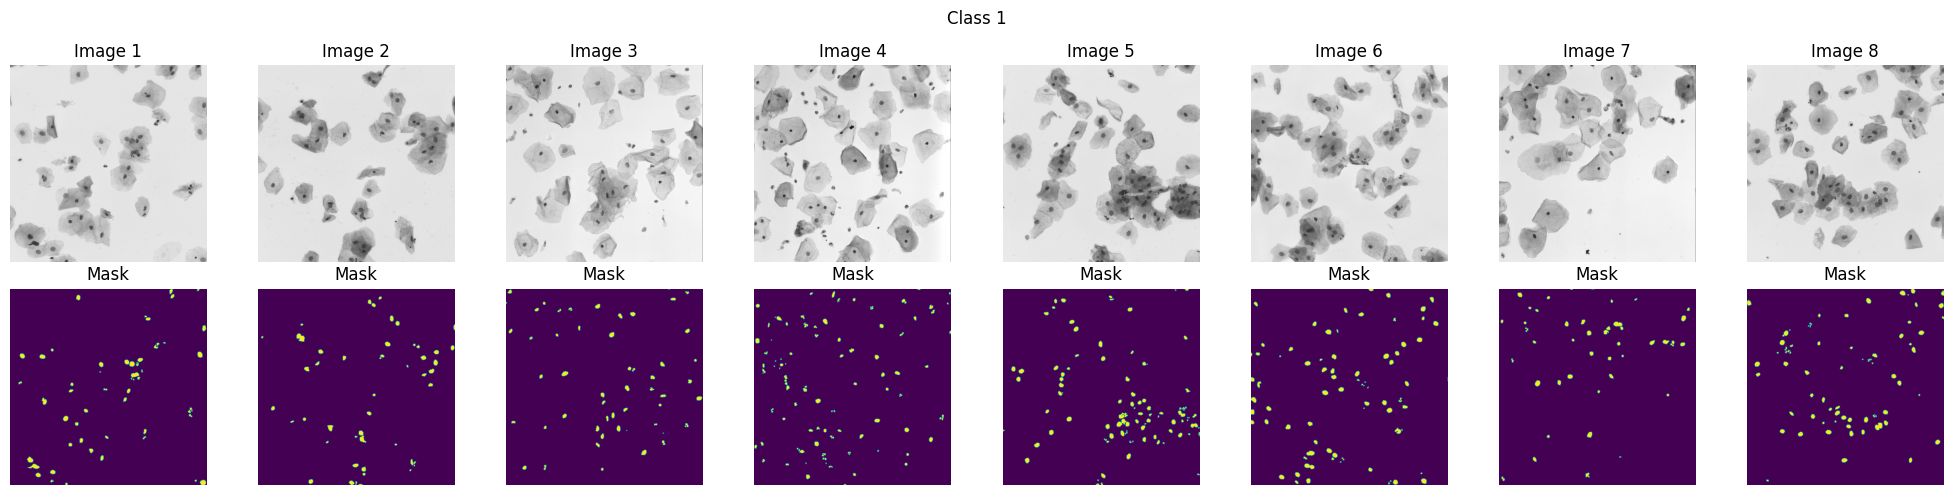

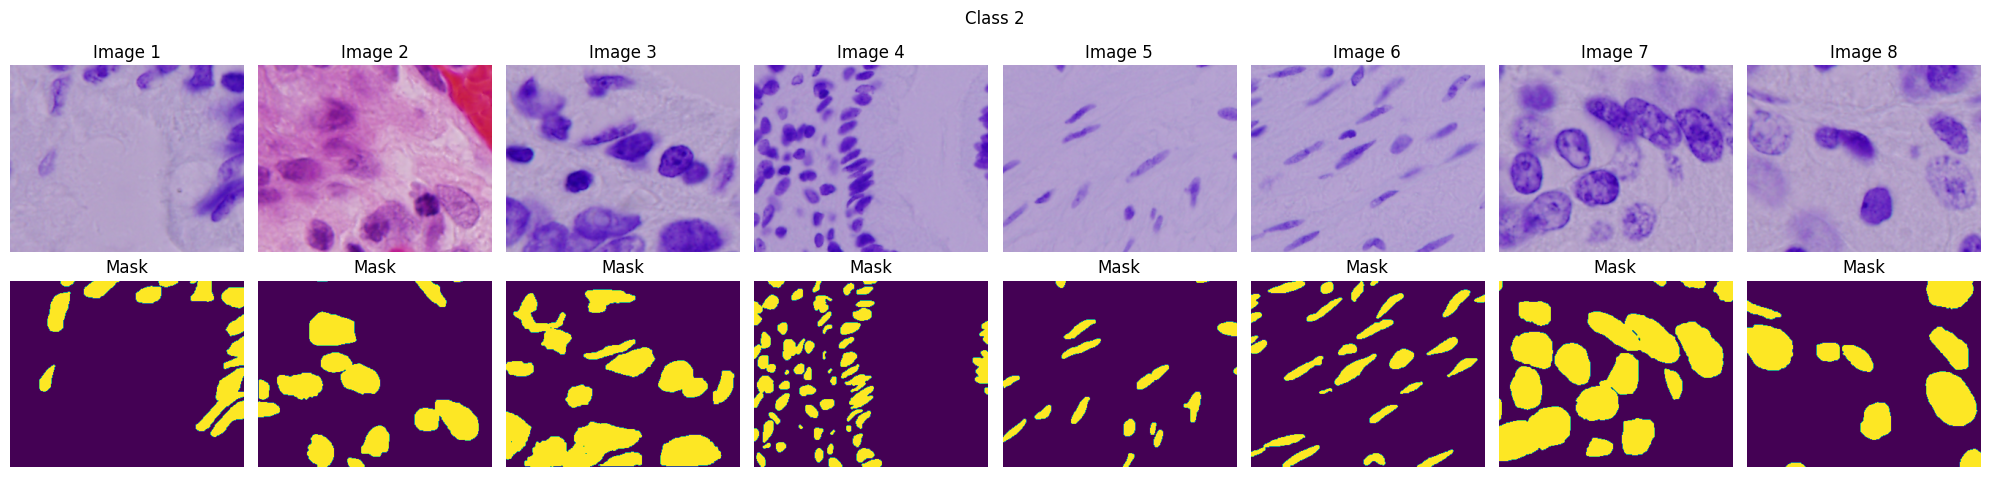

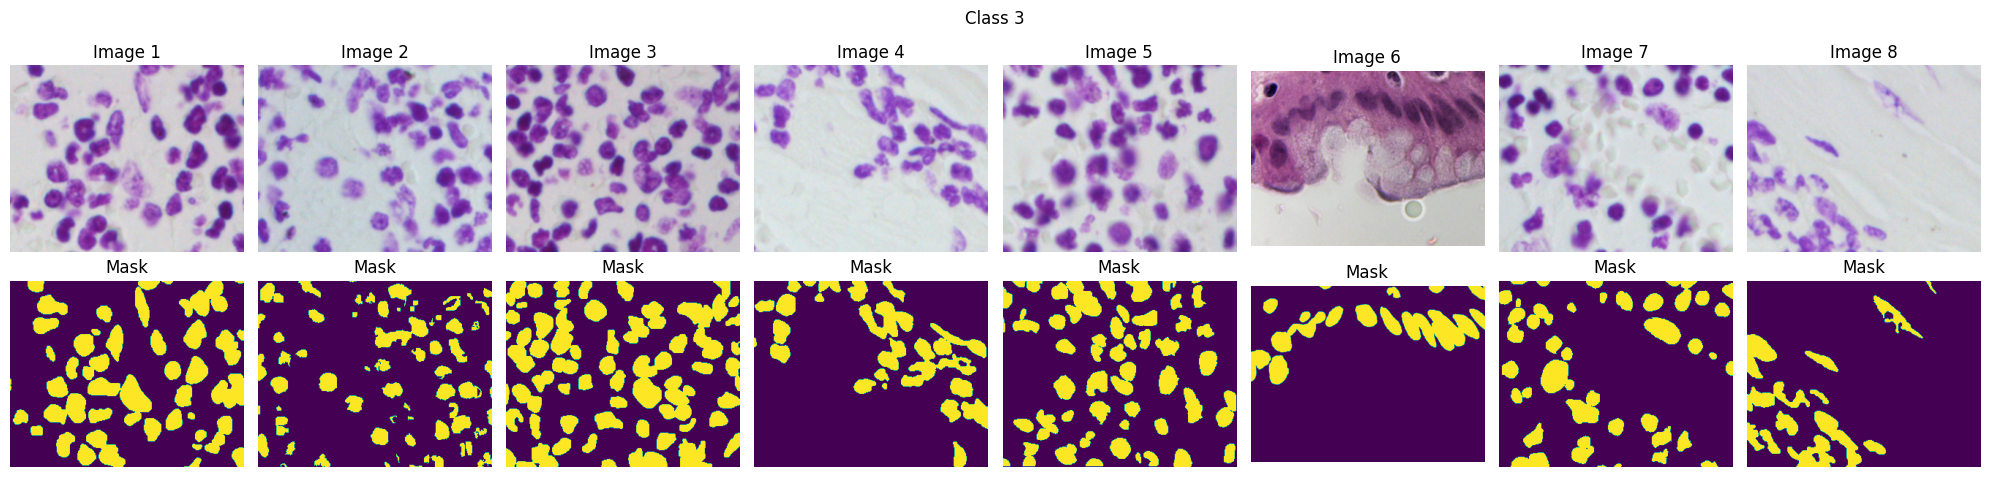

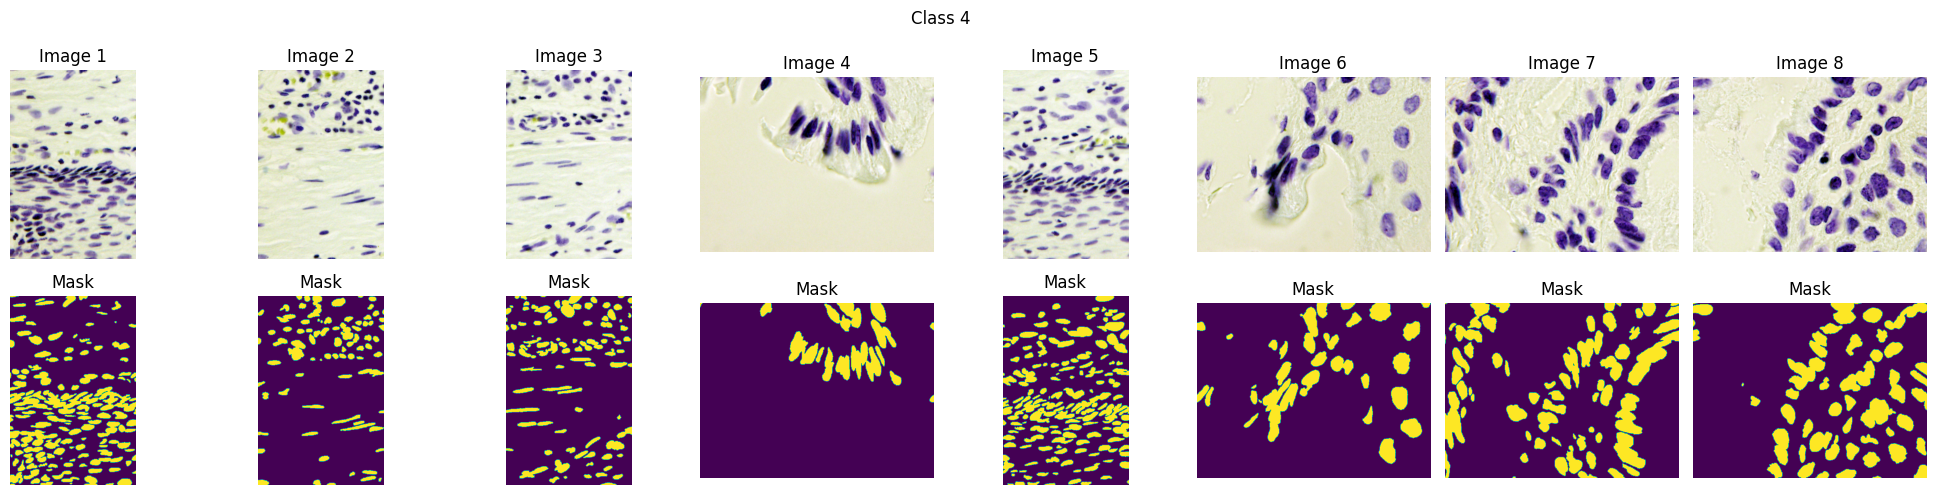

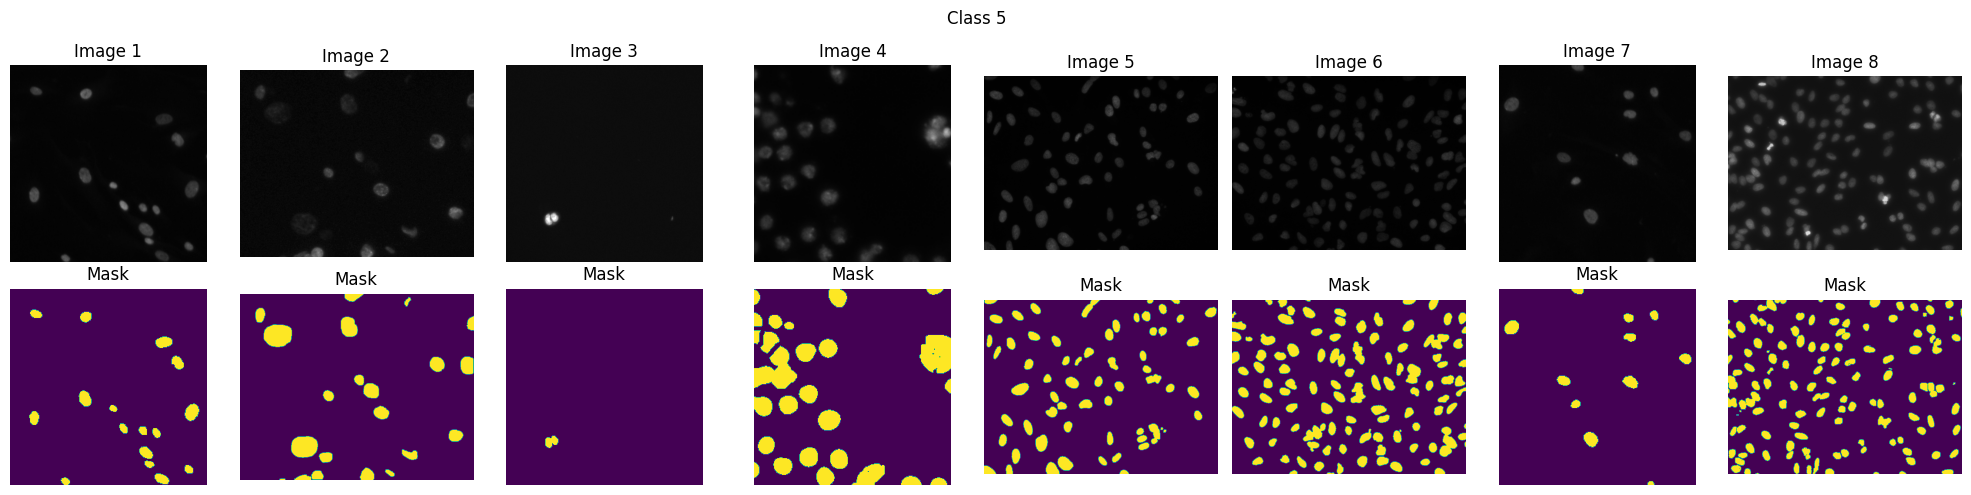

In [ ]:
# set the classes you want to visualize
classes = [1, 2, 3, 4, 5]

# loop over the selected classes and plot the images and masks
for target_class in classes:
    # select all image ids that belong to the target class
    image_ids = categories.loc[categories['class'] == target_class, 'filename'].tolist()

    # select 10 random image ids from the list
    random_image_ids = np.random.choice(image_ids, size=8, replace=False)

    # create a figure to plot the images and masks
    fig, axs = plt.subplots(2, 8, figsize=(20, 5))

    # loop over the selected image ids and plot the corresponding image and mask
    for i, image_id in enumerate(random_image_ids):
        # load the image and mask
        image = imread(f'/content/AllTrainData/{image_id}/images/{image_id}.png')
        height, width = image.shape[:2]
        mask = np.zeros((height, width))
        for mask_file in os.listdir(f'/content/AllTrainData/{image_id}/masks/'):
            mask_ = imread(f'/content/AllTrainData/{image_id}/masks/{mask_file}')
            mask += mask_
        mask = np.clip(mask, 0, 1)
        # plot the image and mask
        axs[0, i].imshow(image)
        axs[0, i].set_title(f'Image {i+1}')
        axs[0, i].axis('off')
        axs[1, i].imshow(mask)
        axs[1, i].set_title('Mask')
        axs[1, i].axis('off')

    # set the title of the figure
    fig.suptitle(f'Class {target_class}')

    plt.tight_layout()
    plt.show()


In [ ]:
num_images = categories['class'].value_counts()
print(num_images)

5    599
2     71
3     41
1     16
4      8
Name: class, dtype: int64


##Creation of train / val split using the classes

In [ ]:
indices = [categories['filename'].tolist().index(id_) for id_ in alltrain_ids]

# Reorder the rows in the DataFrame based on the indices
categories_reordered = categories.iloc[indices]
categories_reordered = categories_reordered.reset_index(drop=True)
# Check that the order is the same
print(categories_reordered['filename'].tolist() == alltrain_ids)

True


In [ ]:
# Split the data into training and validation sets based on the "category" column
train_ids, val_ids = train_test_split(categories_reordered['filename'], 
                                      test_size=0.25, 
                                      stratify=categories_reordered['class'],
                                      random_state=42)
# Load train images and masks
X_train = []
Y_train = []
print('Loading train images and masks ... ')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = alltrain_ids_path + id_
    img = imread(path + '/images/' + id_ + '.png')
    X_train.append(img)
    mask = np.zeros((img.shape[0], img.shape[1], 1))
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(mask_, axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train.append(mask)
X_train = np.array(X_train)
Y_train = np.array(Y_train)
Y_train /= 255
print('Done loading train images and masks!')

# Load validation images and masks
X_val = []
Y_val = []
print('Loading validation images and masks ... ')
for n, id_ in tqdm(enumerate(val_ids), total=len(val_ids)):
    path = alltrain_ids_path + id_
    img = imread(path + '/images/' + id_ + '.png')
    X_val.append(img)
    mask = np.zeros((img.shape[0], img.shape[1], 1))
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(mask_, axis=-1)
        mask = np.maximum(mask, mask_)
    Y_val.append(mask)
X_val = np.array(X_val)
Y_val = np.array(Y_val)
Y_val /= 255
print('Done loading validation images and masks!')

Loading train images and masks ... 


100%|██████████| 551/551 [05:25<00:00,  1.69it/s]
<ipython-input-76-4995ab243322>:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train = np.array(X_train)
<ipython-input-76-4995ab243322>:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Y_train = np.array(Y_train)


Done loading train images and masks!
Loading validation images and masks ... 


100%|██████████| 184/184 [03:19<00:00,  1.09s/it]

Done loading validation images and masks!



<ipython-input-76-4995ab243322>:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_val = np.array(X_val)
<ipython-input-76-4995ab243322>:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Y_val = np.array(Y_val)


In [ ]:
train_ids = np.array(train_ids)
val_ids = np.array(val_ids)

In [ ]:
# Initialize a list to store indices for each class
chosen_indices = []

# Iterate over unique classes in the DataFrame
for c in categories_reordered['class'].unique():
    # Get all IDs in the validation set for this class
    ids_for_class = categories_reordered.loc[(categories_reordered['class'] == c) & 
                                   (categories_reordered['filename'].isin(val_ids)), 'filename'].tolist()
    # Choose one ID at random for this class
    chosen_id = np.random.choice(ids_for_class)
    # Store the index of the chosen ID in the original val_ids array
    chosen_indices.append(np.where(val_ids == chosen_id)[0][0])

[57, 74, 56, 85, 98]


In [ ]:
np.save("/content/gdrive/MyDrive/FINAL/DATA/X_TRAIN.npy",X_train)
np.save("/content/gdrive/MyDrive/FINAL/DATA/Y_TRAIN.npy",Y_train)
np.save("/content/gdrive/MyDrive/FINAL/DATA/X_VAL.npy",X_val)
np.save("/content/gdrive/MyDrive/FINAL/DATA/Y_VAL.npy",Y_val)

In [ ]:
np.save("/content/gdrive/MyDrive/FINAL/DATA/train_ids.npy",train_ids)
np.save("/content/gdrive/MyDrive/FINAL/DATA/val_ids.npy",val_ids)
np.save("/content/gdrive/MyDrive/FINAL/DATA/all_ids.npy",alltrain_ids)
np.save("/content/gdrive/MyDrive/FINAL/DATA/val_example_indices.npy",chosen_indices)

# Loading in data & creating model

## Loading Data

In [45]:
def getFilePath(name):
  if name == 'Wannes':
    return '/content/gdrive/MyDrive/Colab_Notebooks/Final_Project/Data/'
  elif name == 'Matteo':
    return '/content/gdrive/MyDrive/FINAL/DATA/'
  elif name == 'Tom':
    return ''
  elif name == 'Ward':
    return ''
  elif name == 'Milan':
    return ''

In [46]:
FILE_PATH = getFilePath(name='Matteo')
X_train = np.load(FILE_PATH + 'X_TRAIN.npy' ,allow_pickle=True)
Y_train = np.load(FILE_PATH + 'Y_TRAIN.npy',allow_pickle=True)
X_val = np.load(FILE_PATH + 'X_VAL.npy',allow_pickle=True)
Y_val = np.load(FILE_PATH + 'Y_VAL.npy',allow_pickle=True)


from PIL import Image 
import numpy as np

def remove_fourth_dimension(image):
    # add an extra dimension to the third channel
    if image.shape[2]==4:
      
      image=image[:,:,0:3]
    return image

# if the model only needs 3 dimension

for i in range(X_train.shape[0]):
  X_train[i]= remove_fourth_dimension(X_train[i])

for i in range(X_val.shape[0]):
  X_val[i]= remove_fourth_dimension(X_val[i])


# for i, img in enumerate(X_train):
#     if img.shape[2] == 3:  # Add fourth channel with default value of 255
#         X_train[i] = np.dstack([img, np.full_like(img[:, :, 0], 255)])
# for i, img in enumerate(Y_train):
#     if img.shape[2] == 3:  # Add fourth channel with default value of 255
#         Y_train[i] = np.dstack([img, np.full_like(img[:, :, 0], 255)])
# for i, img in enumerate(X_val):
#     if img.shape[2] == 3:  # Add fourth channel with default value of 255
#         X_val[i] = np.dstack([img, np.full_like(img[:, :, 0], 255)])        
# for i, img in enumerate(Y_val):
#     if img.shape[2] == 3:  # Add fourth channel with default value of 255
#         Y_val[i] = np.dstack([img, np.full_like(img[:, :, 0], 255)])   

In [47]:
# Load in the train & val ids (needed for plotting)
train_ids = np.load(FILE_PATH + 'train_ids.npy' ,allow_pickle=True)
val_ids = np.load(FILE_PATH + 'val_ids.npy' ,allow_pickle=True)
all_ids = np.load(FILE_PATH + 'all_ids.npy' ,allow_pickle=True)
val_example_indices = np.load(FILE_PATH + 'val_example_indices.npy' ,allow_pickle=True)

In [48]:
def plotValidationXandY(X_val, Y_val, indices = val_example_indices ):
    fig, axs = plt.subplots(nrows=2, ncols=len(indices), figsize=(15, 5))
    for i, idx in enumerate(indices):
        # Get the image and its label mask
        x = X_val[idx]
        y = Y_val[idx]

        # Plot the image and its label mask as separate subplots
        axs[0][i].imshow(x)
        axs[1][i].imshow(y)

    plt.show()

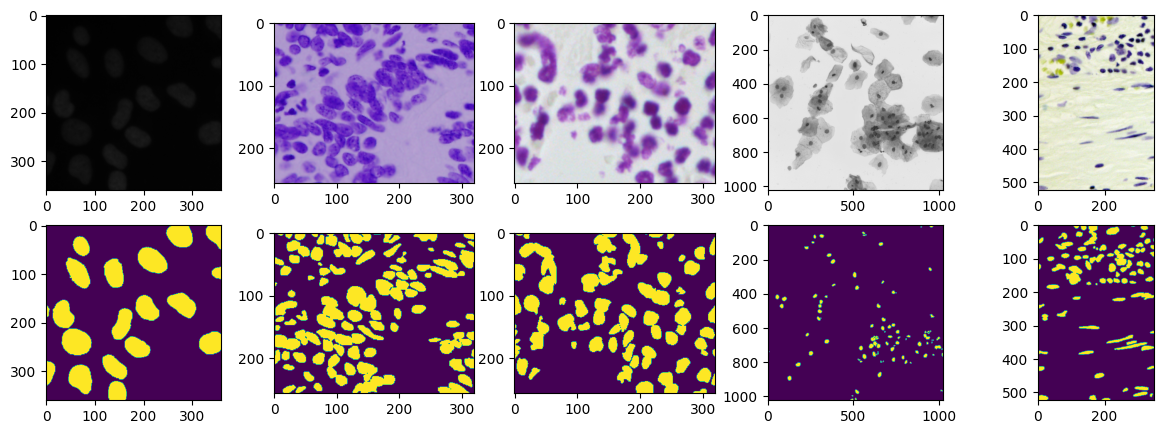

In [7]:
plotValidationXandY(X_val,Y_val)

# Preprocessing

In [6]:
import cv2
import numpy as np

def convert_to_gray(images):
    """
    Converts an array of images to grayscale and removes alpha channel (if exists).

    Args:
        images (numpy.ndarray): Array of images, where each image is represented as a numpy array.

    Returns:
        numpy.ndarray: Array of grayscale images, where each image is represented as a numpy array.
    """
    gray_images = []

    for img in images:
        if len(img.shape) == 3 and img.shape[2] == 3:
            # convert color image to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        elif len(img.shape) == 3 and img.shape[2] == 4:
            # remove alpha channel and convert to grayscale
            img_rgb = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
            gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
        elif len(img.shape) == 2 or img.shape[2] == 1:
            # already a grayscale image, no need to convert
            gray = img
        else:
            # not a valid image format
            raise ValueError("Invalid image format")

        gray_images.append(gray)

    gray_images = np.array(gray_images)
    
    return gray_images

In [7]:
X_train_gray = convert_to_gray(X_train)
X_val_gray = convert_to_gray(X_val)

<ipython-input-6-404602bdfc88>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  gray_images = np.array(gray_images)


# Deterministic cropping 

In [57]:
import numpy as np
import cv2
import math 
def create_overlapping_crops(image, crop_size=128, stride=100):
    # Get the dimensions of the image
    h, w = image.shape[:2]
    # Calculate the number of crops in the x and y direction
    num_crops_x= int(np.floor(w/stride)+1)
    num_crops_y=int(np.floor(h/stride)+1)

    #case image is appropiate already 
    if h == crop_size and w == crop_size: 
      return np.reshape(image, (1, image.shape[0], image.shape[1], image.shape[2])), image.shape

    else:
      # Initialize an empty array to store the crops
      crops = np.zeros(((num_crops_x +1 )* (num_crops_y+1), crop_size, crop_size, image.shape[2]), dtype=np.uint8)
      # Create the crops
      count = 0
      for y in range(0, h  , stride):
          # If we're at the bottom edge of the image, use a smaller stride value
          if y+crop_size > h:
              y = h - crop_size
          for x_use in range(0, w , stride):
            #tmp -> bijhouden waar vorige x was zodat we geen overlapping hebben 
              tmp = -1 
              if x_use != 0: 
                tmp = x 
              x = x_use
              # If we're at the right edge of the image, use a smaller stride value
              if x_use+crop_size > w:
                  x = w - crop_size
              if tmp != x: 
                crop = image[y:y+crop_size, x:x+crop_size, :]
                crops[count] = crop
                count += 1

      
      return crops[:count], image.shape

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def plot_overlapping_crops(crops):

   
    # Determine the number of rows and columns in the grid of images
    num_crops = crops.shape[0]
  

    num_cols = int(np.sqrt(num_crops))
    num_rows = int(np.ceil(num_crops / num_cols))
    if num_cols == 1 and num_rows == 1: 
      imshow(crops[0])
      plt.show()
    else:
      # Create the grid of images
      fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
      for i in range(num_rows ):
          for j in range(num_cols):
              index = i*num_cols + j
              if index < num_crops:
                  axes[i,j].imshow(crops[index])
                  axes[i,j].set_xticks([])
                  axes[i,j].set_yticks([])
              else:
                  axes[i,j].axis('off')

    plt.show()

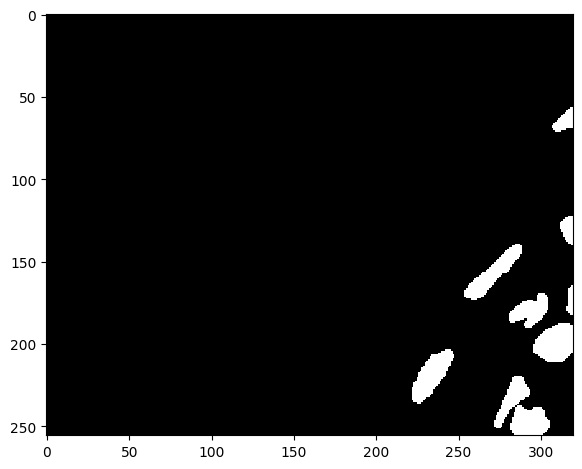

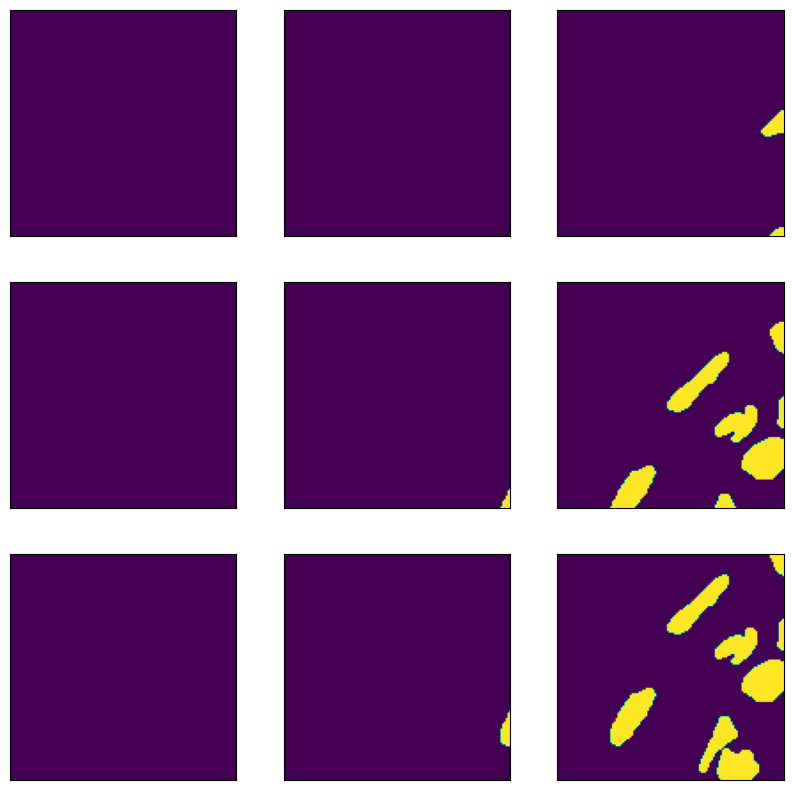

In [ ]:
imshow(Y_val[7])
plt.show()
#imshow(np.squeeze(Y_val[121]))
# plt.show()
plot_overlapping_crops(create_overlapping_crops(Y_val[7])[0])
# plot_crops(y1, num_cols=5 )

## recombine 

In [56]:
# if you know the stride it is not too difficult 
def recombine_overlapping_crops(overlapping_crops,stride=100, crop_size=128): 

  # if it is the original image, no recombining is needed
  if overlapping_crops[0].shape[0]==1: 
    return np.reshape(overlapping_crops[0],(overlapping_crops[0].shape[1],overlapping_crops[0].shape[2],overlapping_crops[0].shape[3]))


  # initialize matrices already in the proper shape   
  matrix_nr_overlaps= np.zeros(overlapping_crops[1])
  matrix_sum= np.zeros(overlapping_crops[1])

  # determine the number of crops  
  # calculate the division 
  num_crops_y=0
  num_crops_x=0

  for i in range(1000): 
    if stride*i+crop_size>= overlapping_crops[1][0]:
      num_crops_y=i+1
      break
  for i in range(1000): 
    if stride*i+crop_size>= overlapping_crops[1][1]:
      num_crops_x=i+1
      break



#   division_1= overlapping_crops[1][0]/stride
# # if it is an integer by nature, no need to add a 1
#   if(division_1==int(division_1)): 
#     num_crops_y= int(division_1)
#   else:
#     num_crops_y= int(np.floor(division_1)+1)
  
#   division_2= overlapping_crops[1][1]/stride

#   if(division_2==int(division_2)): 
#     num_crops_x=int( division_2)
#   else:
#     num_crops_x= int(np.floor(division_2)+1)
  
  # how much does it need to be shifted to left/up? 
  places_short_x= (num_crops_x-1)*stride+crop_size-overlapping_crops[1][1]
  places_short_y= (num_crops_y-1)*stride+crop_size-overlapping_crops[1][0]
  

  counter=0 # allows to index the different crops
  
  for j in range(num_crops_y): 
    for i in range(num_crops_x): 
      
      # in this case, one is at the bottom right of the image
      if (i==num_crops_x-1 and j== num_crops_y-1): 
        
        matrix_sum[ j*stride-places_short_y:(j)*stride+crop_size-places_short_y,i*stride-places_short_x:i*stride+crop_size-places_short_x]= np.add(matrix_sum[ j*stride-places_short_y:(j)*stride+crop_size-places_short_y,i*stride-places_short_x:i*stride+crop_size-places_short_x], overlapping_crops[0][counter])
        
        matrix_nr_overlaps[ j*stride-places_short_y:(j)*stride+crop_size-places_short_y,i*stride-places_short_x:i*stride+crop_size-places_short_x]=        np.add(matrix_nr_overlaps[ j*stride-places_short_y:(j)*stride+crop_size-places_short_y,i*stride-places_short_x:i*stride+crop_size-places_short_x], np.ones(overlapping_crops[0][counter].shape))

      elif(j== num_crops_y-1): 
        
        matrix_sum[ j*stride-places_short_y:(j)*stride+crop_size-places_short_y, i*stride:i*stride+crop_size]=  np.add(matrix_sum[ j*stride-places_short_y:(j)*stride+crop_size-places_short_y, i*stride:i*stride+crop_size], overlapping_crops[0][counter])
        
        matrix_nr_overlaps[ j*stride-places_short_y:(j)*stride+crop_size-places_short_y, i*stride:i*stride+crop_size]=        np.add(matrix_nr_overlaps[ j*stride-places_short_y:(j)*stride+crop_size-places_short_y, i*stride:i*stride+crop_size], np.ones(overlapping_crops[0][counter].shape))


      
      elif(i==num_crops_x-1):
        matrix_sum[ j*stride:j*stride+crop_size,i*stride-places_short_x:(i)*stride+crop_size-places_short_x]=         np.add(matrix_sum[ j*stride:j*stride+crop_size,i*stride-places_short_x:(i)*stride+crop_size-places_short_x],overlapping_crops[0][counter])

        matrix_nr_overlaps[ j*stride:j*stride+crop_size,i*stride-places_short_x:(i)*stride+crop_size-places_short_x]=         np.add(matrix_nr_overlaps[ j*stride:j*stride+crop_size,i*stride-places_short_x:(i)*stride+crop_size-places_short_x],np.ones(overlapping_crops[0][counter].shape))


        #matrix_sum[j*num_crops_x*crop_size*crop_size+i*crop_size*crop_size-places_short_x: j*num_crops_x*crop_size*crop_size+(i+1)*crop_size*crop_size-places_short_x]
      else: 
        
        
        matrix_sum[j*stride:j*stride+crop_size, i*stride:i*stride+crop_size]= np.add(matrix_sum[j*stride:j*stride+crop_size, i*stride:i*stride+crop_size],overlapping_crops[0][counter])
        matrix_nr_overlaps[j*stride:j*stride+crop_size, i*stride:i*stride+crop_size]= np.add(matrix_nr_overlaps[j*stride:j*stride+crop_size, i*stride:i*stride+crop_size],np.ones(overlapping_crops[0][counter].shape))
      
      counter+=1 
        #matrix_sum[j*num_crops_x*crop_size*crop_size+i*crop_size*crop_size: j*num_crops_x*crop_size*crop_size+(i+1)*crop_size*crop_size]
        # 1: 0:65 536
        #2: 65 536 : 131 072
        #3: 
# reshape 
  output_matrix=np.divide( matrix_sum, matrix_nr_overlaps, )
  output= np.reshape(output_matrix,(overlapping_crops[1]) )
  return output

In [ ]:
# write a for loop that checks for each observation if it works 
def check_cropping(dataset=X_train, stride=100, cropping_size=128):
  boolean_array= np.zeros(dataset.shape[0])
  for i in range (dataset.shape[0]): 
    # create crops 
    cropped= create_overlapping_crops(dataset[i], crop_size= cropping_size, stride=stride)
    recombined= recombine_overlapping_crops(cropped, crop_size= cropping_size, stride=stride )
    boolean_array[i]= np.array_equal(dataset[i],recombined)
  return np.unique(boolean_array==1), boolean_array


In [ ]:
check_cropping(X_train, stride=50, cropping_size=128)[1]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

# Splitting up masks 


In [ ]:
import skimage.io
import numpy as np
from skimage.morphology import label
from skimage.color import label2rgb
from skimage.io import imshow
import matplotlib.pyplot as plt

# we dont need and dont like warnings, this is dangerous world we are living in
import warnings
warnings.filterwarnings('ignore')

image_id = '00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552'
img = skimage.io.imread('../content/stage1_train/{}/images/{}.png'.format(image_id, image_id))[:, :, :3]
# combine masks as one
masks = skimage.io.imread_collection('../content/stage1_train/{}/masks/*.png'.format(image_id)).concatenate()
mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
for maskItem_ in masks:
    mask = np.maximum(mask, (maskItem_ == 255))
    
print("Source image")
imshow(img)
plt.show()

print("Combined mask image with overlapping objects")
labels = label(mask)
imshow(labels)
plt.show()

FileNotFoundError: ignored

In [ ]:
from skimage.measure import regionprops
from skimage.morphology import convex_hull_image
from skimage.segmentation import find_boundaries
import math
from itertools import combinations

def extendLineToMask(y1,x1,y2,x2,mask):
    if (y1 < 0) or (y2 < 0) or (x1 < 0) or (x2 < 0): # input validation
        return 0,0,0,0
    
    tc = (np.array([y1, x1])+np.array([y2, x2]))/2.0 # get center point
    
    # extend line to image bound
    if (x2 - x1 == 0): 
        # is vertical line
        extendedLineY1 = 0
        extendedLineX1 = x1
        extendedLineY2 = mask.shape[0]-1
        extendedLineX2 = x2
    else: 
        # not vertical
        # calculate slope
        # use skimage line for better slope calculation
        rrP1, ccP1 = skimage.draw.line(int(y1), int(x1), int(y2), int(x2))      
        m = ((ccP1*rrP1).mean() - ccP1.mean()*rrP1.mean()) / ((ccP1**2).mean() - (ccP1.mean())**2)
        if (m == 0.0):
            return 0,0,0,0
        # calculate b
        b = y1-(m*x1)
        
        extendedLineX1 = 0
        extendedLineY1 = m * extendedLineX1 + b # y = mx+b
        #out of bound handling
        if (extendedLineY1 < 0) or (extendedLineY1 > mask.shape[0]):
            # get min/max Y
            extendedLineY1 = max(min(mask.shape[0]-1, extendedLineY1), 0.0)
            # recalculate X
            extendedLineX1 = (extendedLineY1-b) / m
                    
        extendedLineX2 = mask.shape[1]-1
        extendedLineY2 = m * extendedLineX2 + b
        #out of bound handling
        if (extendedLineY2 < 0) or (extendedLineY2 > mask.shape[0]):
            # get min/max Y
            extendedLineY2 = max(min(mask.shape[0]-1, extendedLineY2), 0.0)
            # recalculate X
            extendedLineX2 = (extendedLineY2-b) / m
     # check infinity
    if (math.isinf(extendedLineX1) or math.isinf(extendedLineX2) or math.isinf(extendedLineY1) or math.isinf(extendedLineY2)):
        return 0,0,0,0

    # get extended line
    rrP1, ccP1 = skimage.draw.line(int(extendedLineY1), int(extendedLineX1), int(extendedLineY2), int(extendedLineX2))

    # get index of center point
    linecenterir = np.nonzero(rrP1 == int(tc[0]))[0]
    linecenteric = np.nonzero(ccP1 == int(tc[1]))[0]
    if (len(linecenteric) < len(linecenterir)):
        linecenteri = linecenteric
    else:
        linecenteri = linecenterir
    if (len(linecenteri)) > 0:
        # trim line to mask
        linecenterindex = linecenteri[0]
        try: # there are some situations where issue occurs (line outside image) but I haven't had the time to add validation
            # get left and right part of the line (this is not actually direction of line but indexation of array)
            lineontheleft = mask[rrP1[0:linecenterindex],ccP1[0:linecenterindex]]
            lineontheright = mask[rrP1[linecenterindex:],ccP1[linecenterindex:]]
            # trim to mask
            lineonthelefttrimi = np.nonzero(lineontheleft == False)[0]
            lineontherighttrimi = np.nonzero(lineontheright == False)[0]
            # out of image bounds > better way will be to pad image with 1px False border, but this is faster
            if (len(lineonthelefttrimi) < 1) and (mask[rrP1[0],ccP1[0]] == True):
                lineonthelefttrimi = [-1]
            if (len(lineontherighttrimi) < 1) and (mask[rrP1[-1],ccP1[-1]] == True):
                lineontherighttrimi = [len(rrP1)]
            if (len(lineonthelefttrimi) > 0) and (len(lineontherighttrimi) > 0):
                lineonthelefttrim = lineonthelefttrimi[-1]+1
                lineontherighttrim = linecenterindex+lineontherighttrimi[0]
                if (lineontherighttrim > lineonthelefttrim):
                    extendedLineY1 = rrP1[lineonthelefttrim:lineontherighttrim][0]
                    extendedLineX1 = ccP1[lineonthelefttrim:lineontherighttrim][0]
                    extendedLineY2 = rrP1[lineonthelefttrim:lineontherighttrim][-1]
                    extendedLineX2 = ccP1[lineonthelefttrim:lineontherighttrim][-1]
                else:
                    extendedLineY1 = 0
                    extendedLineX1 = 0
                    extendedLineY2 = 0
                    extendedLineX2 = 0
            else:
                # invalid line
                extendedLineY1 = extendedLineX1 = extendedLineY2 = extendedLineX2 = 0
        except:
            # invalid line
            extendedLineY1 = extendedLineX1 = extendedLineY2 = extendedLineX2 = 0
    else:
        # invalid line
        extendedLineY1 = extendedLineX1 = extendedLineY2 = extendedLineX2 = 0

    # return line coordinates
    return int(extendedLineY1), int(extendedLineX1), int(extendedLineY2), int(extendedLineX2)

# parallel line helper function
def parallelLine(px1, px2, offsetPixels, length=0.0):
    if (length == 0.0):
        length = math.sqrt((px1[1]-px2[1])*(px1[1]-px2[1])+(px1[0]-px2[0])*(px1[0]-px2[0]))
    x1p = px1[1] + offsetPixels * (px2[0]-px1[0]) / length
    x2p = px2[1] + offsetPixels * (px2[0]-px1[0]) / length
    y1p = px1[0] + offsetPixels * (px1[1]-px2[1]) / length
    y2p = px2[0] + offsetPixels * (px1[1]-px2[1]) / length
    return [y1p,x1p], [y2p,x2p]

def splitValidation(px1, px2, img):
    # calculate line distance
    delta = (px1[1]-px2[1])*(px1[1]-px2[1])+(px1[0]-px2[0])*(px1[0]-px2[0])
    if (delta > 0):
        L = math.sqrt(delta)
    else:
        L = 0
    # get top parallel line
    plpx1a, plpx2a = parallelLine(px1, px2, -4.0, length=L)
    # extend line to bound
    y1pea, x1pea, y2pea, x2pea = extendLineToMask(plpx1a[0], plpx1a[1], plpx2a[0], plpx2a[1], img)
    # get line length
    delta = (x1pea-x2pea)*(x1pea-x2pea)+(y1pea-y2pea)*(y1pea-y2pea)
    if (delta > 0):
        La = math.sqrt(delta)
    else:
        La = 0
    
    # get bottom parallel line
    plpx1b, plpx2b = parallelLine(px1, px2, 4.0, length=L)
    # extend line to bound
    y1peb, x1peb, y2peb, x2peb = extendLineToMask(plpx1b[0], plpx1b[1], plpx2b[0], plpx2b[1], img)
    # if top and bottom line are longer than split line
    delta = (x1peb-x2peb)*(x1peb-x2peb)+(y1peb-y2peb)*(y1peb-y2peb)
    if (delta > 0):
        Lb = math.sqrt(delta)
    else:
        Lb = 0

    plpx1a2, plpx2a2 = parallelLine(px1, px2, -2.0, length=L)
    # extend line to bound
    y1pea2, x1pea2, y2pea2, x2pea2 = extendLineToMask(plpx1a2[0], plpx1a2[1], plpx2a2[0], plpx2a2[1], img)
    # get line length
    delta = (x1pea2-x2pea2)*(x1pea2-x2pea2)+(y1pea2-y2pea2)*(y1pea2-y2pea2)
    if (delta > 0):
        La2 = math.sqrt(delta)
    else:
        La2 = 0
    
    # get bottom parallel line
    plpx1b2, plpx2b2 = parallelLine(px1, px2, 2.0, length=L)
    # extend line to bound
    y1peb2, x1peb2, y2peb2, x2peb2 = extendLineToMask(plpx1b2[0], plpx1b2[1], plpx2b2[0], plpx2b2[1], img)
    # if top and bottom line are longer than split line
    delta = (x1peb2-x2peb2)*(x1peb2-x2peb2)+(y1peb2-y2peb2)*(y1peb-y2peb2)
    if (delta > 0):
        Lb2 = math.sqrt(delta)
    else:
        Lb2 = 0

    #if 5.0 line is bigger than split line and 2.0 line is bigger than 5.0 line
    #if -5.0 line is bigger than split line and -2.0 line is bigger than -5.0 line
    return (La >= L-2) and (La >= La2) and (Lb >= L-2) and (Lb >= Lb2)

def getCropMaskDimensions(img):
    cropmatrix = np.transpose(img.nonzero())
    cropcoordmin = np.amin(cropmatrix, axis=0)
    cropcoordmax = np.amax(cropmatrix, axis=0)
    cropy = cropcoordmin[0]
    cropx = cropcoordmin[1]
    cropy2 = cropcoordmax[0]+1
    cropx2 = cropcoordmax[1]+1
    return cropy, cropx, cropy2, cropx2
    
def separation(img):
    # make a copy
    inputimg_ = np.copy(img)
    
    # crop image to object bound > this helps speed up the processing
    cropy, cropx, cropy2, cropx2 = getCropMaskDimensions((inputimg_ == True))
    img_ = inputimg_[cropy:cropy2,cropx:cropx2]

    # define minimal convex area
    MIN_CONVEX_AREA = 5
    
    # calculate convex hull of object
    convexhull = convex_hull_image(img_)
    # invert convex hull
    convexhulldiff = img_^convexhull
    # get boundaries > will help speed up processing
    boundaries = find_boundaries(convexhulldiff, connectivity=1, mode='inner')
    # split inset border objects
    label_img = label(boundaries)
    if (label_img.max() > 1):
        # calculate region props
        regions = regionprops(label_img)
        # get candidates
        objectcandidates = []
        for props in regions:
            # limit to min convex area size
            if props.convex_area > MIN_CONVEX_AREA:
                y0, x0 = props.centroid # this is not used
                orientation = props.orientation # this is not used
                #convert image to points > will speed up processing
                objimg = label_img == props.label
                points_ = []
                for row_ in range(0,objimg.shape[0]):
                    for col_ in range(0,objimg.shape[1]):
                        if (objimg[row_][col_]):
                            points_.append([row_, col_])

                objectcandidates.append([orientation, points_])

        #get potential pairs
        for c in combinations(range(0,len(objectcandidates)), 2):
            # object A
            iobjA = c[0]
            # object B
            iobjB = c[1]
            # x,y border points for objects
            xy1 = np.array(objectcandidates[iobjA][1])
            xy2 = np.array(objectcandidates[iobjB][1])
            # numpy optimized way to findx nearest points between two objects
            P = np.add.outer(np.sum(xy1**2, axis=1), np.sum(xy2**2, axis=1))
            N = np.dot(xy1, xy2.T)
            dists = np.sqrt(P - 2*N)

            # find minimal distance pixel
            distsm_ = np.argmin(dists)
            # convert minimal pixel to x,y grid
            distsmp_ = divmod(distsm_, dists.shape[1])
            # convert to absolute position
            px1 = objectcandidates[iobjA][1][distsmp_[0]]
            px2 = objectcandidates[iobjB][1][distsmp_[1]]
            # separation line
            rr, cc = skimage.draw.line(px1[0], px1[1], px2[0], px2[1])
            line_ = img_[rr, cc]
            # check if line is valid = first check
            if (np.count_nonzero(line_[1:-1] == False) == 0):
                # check if split is valid = second check
                if (splitValidation(px1,px2,img_)):
                    img_[rr, cc] = 0
    # reconstruct image with cropped area
    inputimg_[cropy:cropy2,cropx:cropx2] = img_
    return inputimg_

In [ ]:
#check 
reconstructedMask = np.zeros(mask.shape, dtype=np.bool)
for i in range(1, labels.max() + 1):
    # separate objects
    img_ = separation(labels == i)
    # copy to reconstructed mask
    reconstructedMask = reconstructedMask + img_

labelsFinal = label(reconstructedMask)
      
print("Source mask image")
imshow(label2rgb(labels, bg_label=0))
plt.show()

print("Processed mask image")
imshow(label2rgb(labelsFinal, bg_label=0))
plt.show()

NameError: ignored

#The model


##  Loss function & metric



In [8]:
def dice_coef(y_true, y_pred, smooth=100):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def IoUMetric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

## Random Cropping

In [52]:
class RandomCropGenerator(Sequence):
    def __init__(self, x, y, crop_size, batch_size):
        self.x = x
        self.y = y
        self.crop_size = crop_size
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.x))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.x) / self.batch_size))

    def __getitem__(self, idx):
        batch_x = self.x[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_y = self.y[idx*self.batch_size:(idx+1)*self.batch_size]

        # Perform random cropping on the batch of images
        cropped_x = np.zeros((len(batch_x),) + self.crop_size + (batch_x[0].shape[-1],))
        cropped_y = np.zeros((len(batch_y),) + self.crop_size[:-1] + self.crop_size[:-1] + (1,))

        for i, (image, mask) in enumerate(zip(batch_x, batch_y)):
            x_offset = random.randint(0, image.shape[0] - self.crop_size[0])
            y_offset = random.randint(0, image.shape[1] - self.crop_size[1])
            cropped_x[i] = image[x_offset:x_offset+self.crop_size[0], y_offset:y_offset+self.crop_size[1], :]
            cropped_y[i] = mask[x_offset:x_offset+self.crop_size[0], y_offset:y_offset+self.crop_size[1], ...]
            cropped_x[i] = tf.keras.applications.resnet50.preprocess_input(cropped_x[i])

        return cropped_x, cropped_y

    def on_epoch_end(self):
        np.random.shuffle(self.indexes)
        self.x = [self.x[i] for i in self.indexes]
        self.y = [self.y[i] for i in self.indexes]

# Create an instance of the RandomCropGenerator class
train_generator = RandomCropGenerator(X_train, Y_train, crop_size=(128, 128), batch_size=16)
val_generator = RandomCropGenerator(X_val, Y_val, crop_size=(128, 128), batch_size=16)

In [15]:
batch_x, batch_y = train_generator.__getitem__(0) # get the first batch of data
print(batch_x.shape) # print the shape of the input batch
print(batch_y.shape) # print the shape of the target batch

(16, 128, 128, 3)
(16, 128, 128, 1)


## Training model

In [ ]:
# Initial model try
IMG_CHANNELS = 3
# Define height and width of crop
WIDTH = 128
HEIGHT = 128
# Input Layer
inputs = Input(shape=(WIDTH, HEIGHT, IMG_CHANNELS))

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
## Skip connection from block 4 to 6
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
## Skip connection from block 3 to 7
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
## Skip connection from block 2 to 8
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
## Skip connection from Input block to output block
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

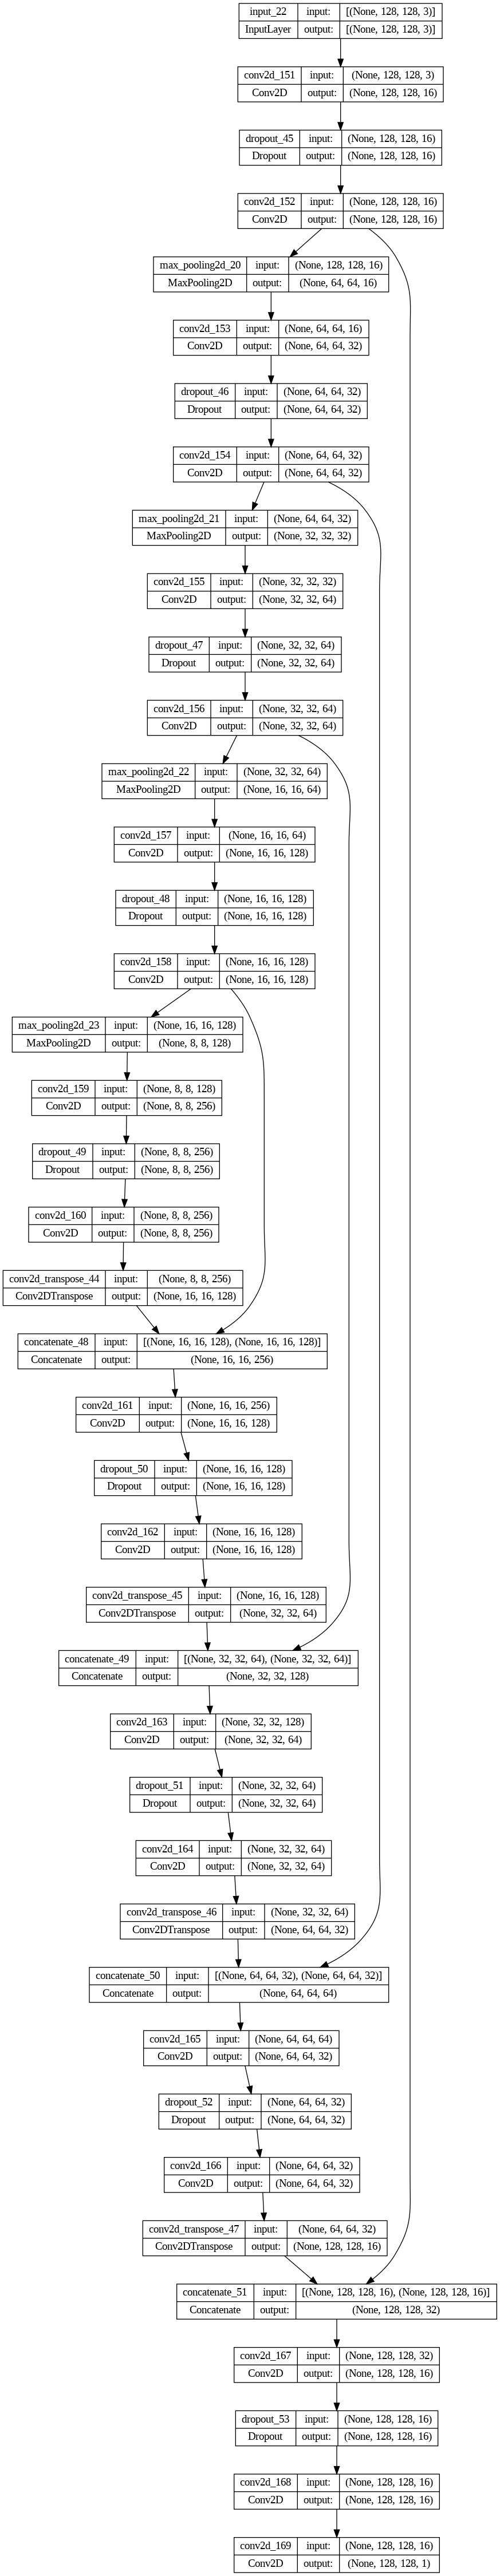

In [ ]:

tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# Compile model
LR = 0.001
model.compile(optimizer=Adam(learning_rate=LR), 
              loss= dice_coef_loss)
model.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_151 (Conv2D)            (None, 128, 128, 16  448         ['input_22[0][0]']               
                                )                                                                 
                                                                                                  
 dropout_45 (Dropout)           (None, 128, 128, 16  0           ['conv2d_151[0][0]']             
                                )                                                          

In [ ]:
# Fit model
EPOCHS = 20
BS = 16
# Get numpy arrays from data generators

earlystopper = EarlyStopping(patience=4, verbose=1)
checkpointer = ModelCheckpoint('Checkpoint.h5', verbose=1, save_best_only=True)
callbacks = [earlystopper, checkpointer]
results = model.fit(train_generator,
                    batch_size=BS,
                    epochs=EPOCHS,
                    validation_data=val_generator,
                    callbacks=callbacks)

Epoch 1/20
 1/35 [..............................] - ETA: 22:13 - loss: 1.8444

In [ ]:
## change to own directory (of zoals in begin naam-afhankelijk maken ofz)
model.save("/content/gdrive/MyDrive/FINAL/InitialModelTrainOnly.h5")

# transfer learning

## First try to use resnet 101 as encoder for U-net model

To Do



1.   Dubbelcheck on the architecture by comparing the created graph to the one created above and general U-net: check stack in code below! 
2.   Make sure the model can run for at least one epoch with randomcropping








In [ ]:
base_model.summary()#use this to check names for down stack

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

In [10]:
import tensorflow as tf

# Load the ResNet101 model pre-trained on ImageNet
base_model = tf.keras.applications.ResNet101(input_shape=[224, 224, 3], include_top=False)

# Specify the intermediate layer names to use as features
layer_names = [
    'conv1_relu',           # 64x64
    'conv2_block3_out',     # 32x32: does it make sense to choose this name?
    'conv3_block4_out',     # 16x16
    'conv4_block23_out',    # 8x8
    'conv5_block3_out',     # 4x4

]

# Get the intermediate outputs for the specified layers
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

# Freeze the weights of the pre-trained model
down_stack.trainable = False


def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[224, 224, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
# Upsampling and establishing the skip connections
    up_stack = [
        tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=3, strides=2, padding='same'),  # 4x4 -> 8x8
        tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=3, strides=2, padding='same'),  # 8x8 -> 16x16
        tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=3, strides=2, padding='same'),  # 16x16 -> 32x32
        tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=3, strides=2, padding='same'),  # 32x32 -> 64x64
         
    ]

    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])
        for i in range(2): 
          x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
        # x = tf.keras.layers.BatchNormalization()(x)
          # x = tf.keras.layers.ReLU()(x)

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2,
        padding='same')  # 64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


171446536/171446536 [==============================] - 9s 0us/step


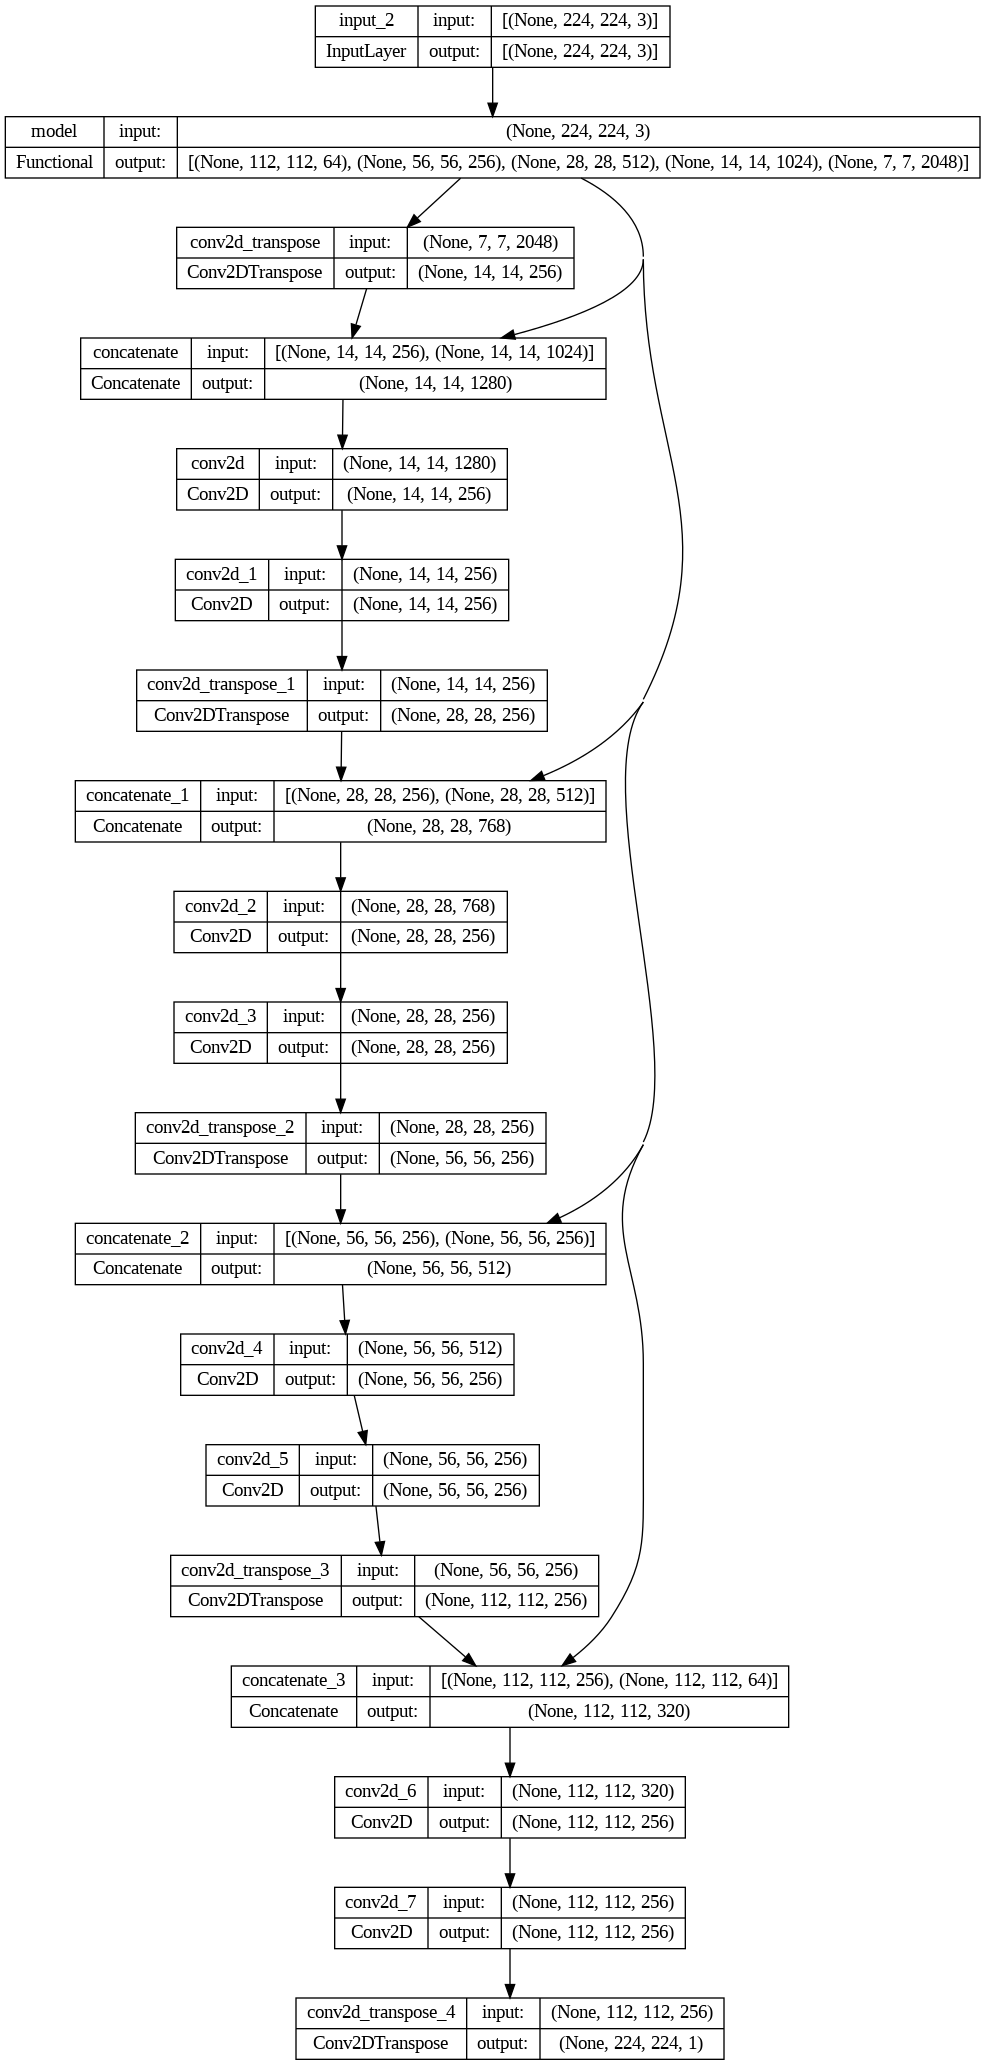

In [11]:
model=unet_model(1)
tf.keras.utils.plot_model(model, show_shapes=True)

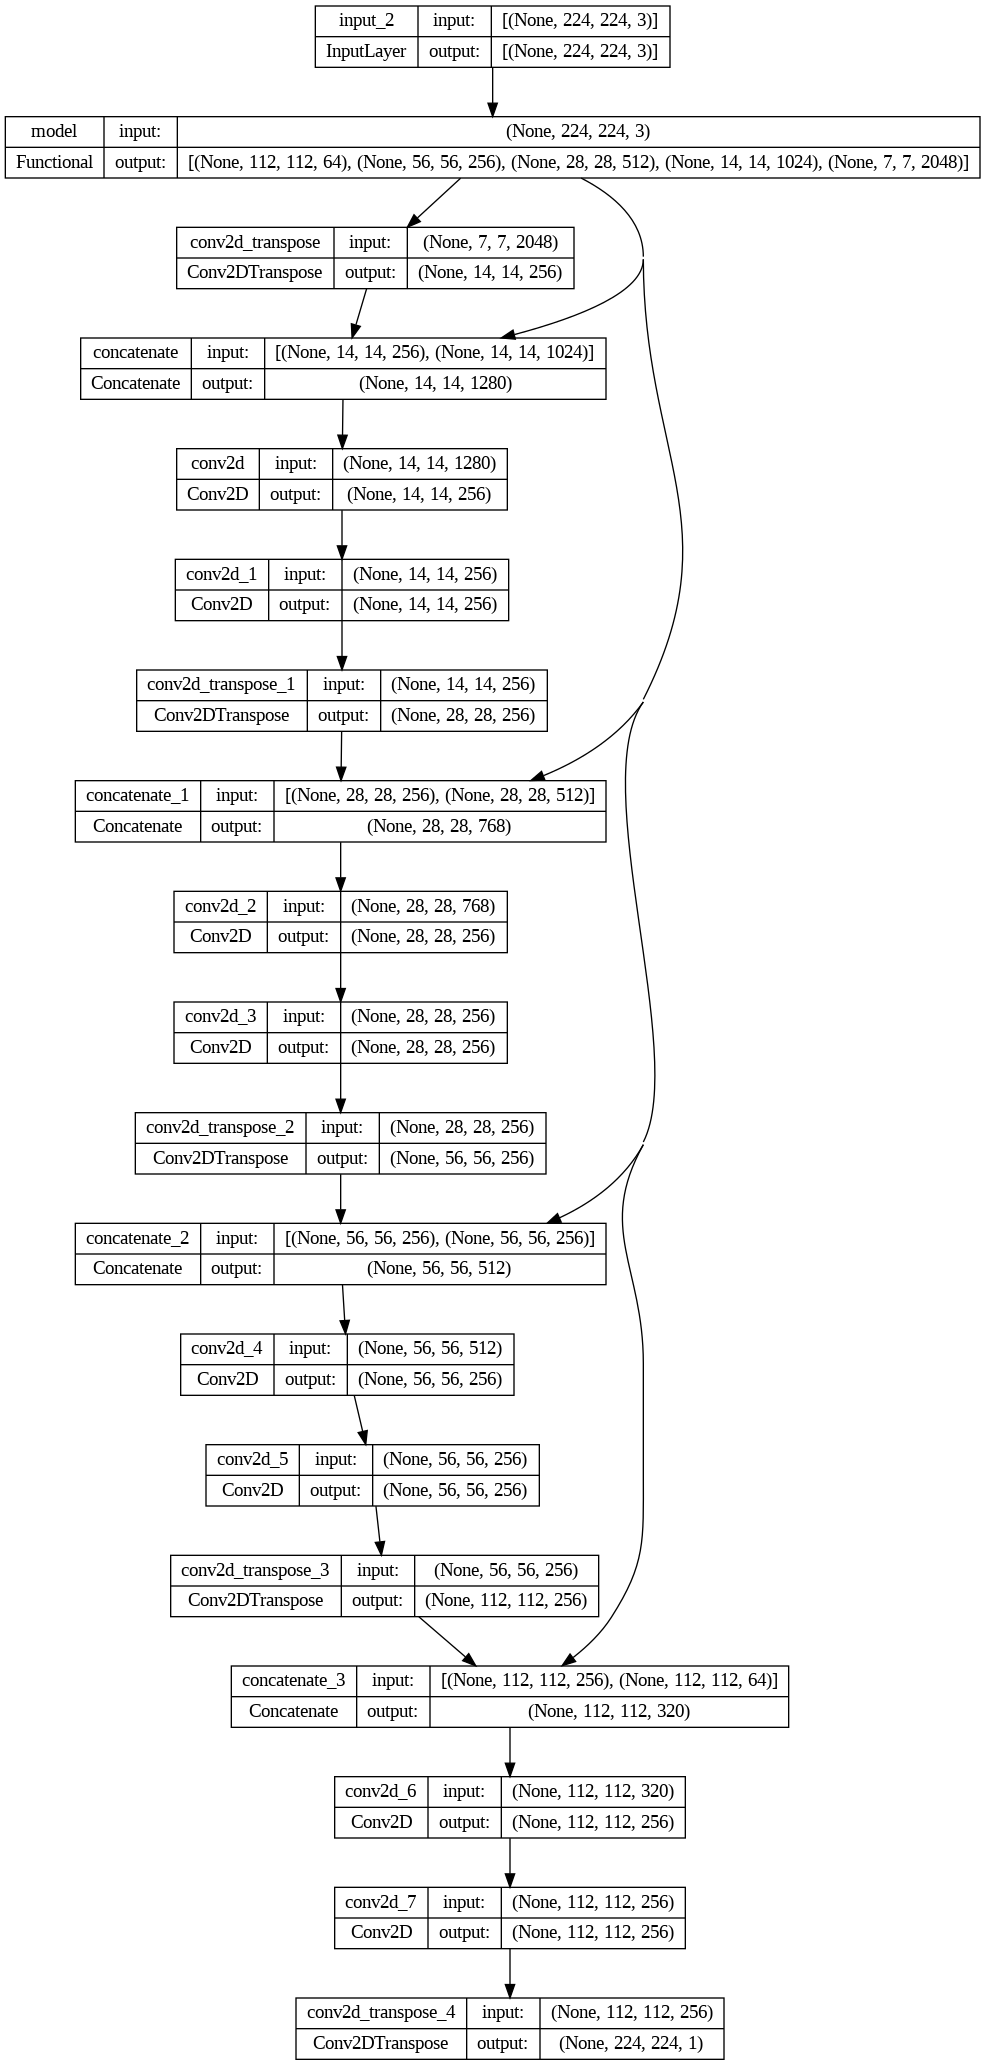

In [19]:
model=unet_model(1)
tf.keras.utils.plot_model(model, show_shapes=True)

In [12]:
# Compile model
LR = 0.001
model.compile(optimizer=Adam(learning_rate=LR), 
              loss= tf.keras.losses.BinaryCrossentropy())
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 112, 112, 6  42658176    ['input_2[0][0]']                
                                4),                                                               
                                 (None, 56, 56, 256                                               
                                ),                                                                
                                 (None, 28, 28, 512                                         

In [50]:
# Create an instance of the RandomCropGenerator class
train_generator = RandomCropGenerator(X_train, Y_train, crop_size=(128, 128), batch_size=16)
val_generator = RandomCropGenerator(X_val, Y_val, crop_size=(224, 224), batch_size=16)

In [49]:
x= tf.keras.applications.resnet50.preprocess_input(train_generator)

TypeError: ignored

In [28]:
type(x)

keras.engine.functional.Functional

In [ ]:
print(X_train_sequential[0].shape)
print(Y_train_sequential[0].shape)

print(X_val_sequential[0].shape)
print(Y_val_sequential[0].shape)



(224, 224, 3)
(224, 224, 1)
(224, 224, 3)
(224, 224, 1)


In [53]:
# Fit model
EPOCHS = 120
BS = 16
# Get numpy arrays from data generators



earlystopper = EarlyStopping(patience=25, verbose=1)
checkpointer = ModelCheckpoint('Checkpoint.h5', verbose=1, save_best_only=True)
callbacks = [earlystopper, checkpointer]
results = model.fit(train_generator,
                    batch_size=BS,
                    epochs=EPOCHS,
                    validation_data=val_generator,
                    callbacks=callbacks)

 

Epoch 1/120
35/35 [==============================] - ETA: 0s - loss: 11.2373
Epoch 1: val_loss improved from inf to 11.66006, saving model to Checkpoint.h5
35/35 [==============================] - 28s 362ms/step - loss: 11.2373 - val_loss: 11.6601
Epoch 2/120
35/35 [==============================] - ETA: 0s - loss: 11.7733
Epoch 2: val_loss improved from 11.66006 to 11.61534, saving model to Checkpoint.h5
35/35 [==============================] - 9s 254ms/step - loss: 11.7733 - val_loss: 11.6153
Epoch 3/120
35/35 [==============================] - ETA: 0s - loss: 11.7322
Epoch 3: val_loss did not improve from 11.61534
35/35 [==============================] - 7s 207ms/step - loss: 11.7322 - val_loss: 11.6271
Epoch 4/120
35/35 [==============================] - ETA: 0s - loss: 11.7751
Epoch 4: val_loss did not improve from 11.61534
35/35 [==============================] - 7s 201ms/step - loss: 11.7751 - val_loss: 11.6674
Epoch 5/120
35/35 [==============================] - ETA: 0s - loss:

Trekt dit op iets?? Neen :) 

In [67]:
# do not forget to adapt preprocessing!
print(avg_iou)

0.0


In [64]:
def calculate_average_iou(model, X_val, Y_val):
    total_iou = 0
    masks = []
    for i in tqdm(range(len(X_val))):
        x = X_val[i]
        img = tf.keras.applications.resnet50.preprocess_input(x)
        img, shape = create_overlapping_crops(x, 224)
        prediction = model.predict(img, verbose=0)
        prediction = (prediction > 0.5).astype(np.uint8)
        overlapping_crops = []
        overlapping_crops.append(prediction)
        overlapping_crops.append(shape)
        mask = recombine_overlapping_crops(overlapping_crops, 100, 224)
        mask = mask[..., :1] 
        val_metric = IoUMetric(Y_val[i], mask)
        total_iou += val_metric
        masks.append(mask)
    avg_iou = total_iou / len(X_val)
    return avg_iou, masks

100%|██████████| 14/14 [00:05<00:00,  2.39it/s]


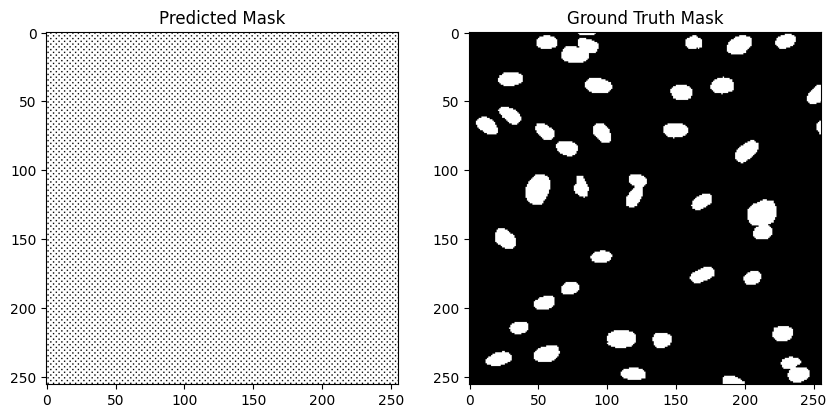

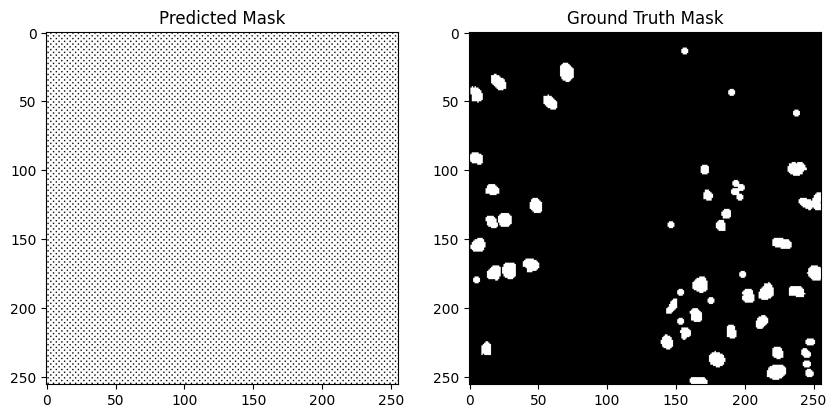

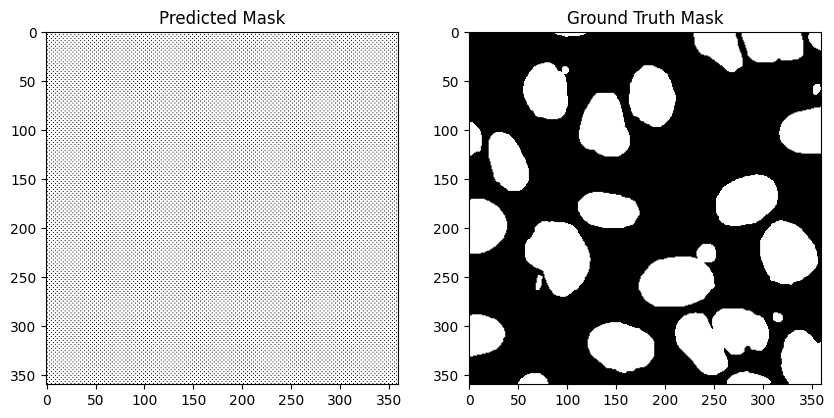

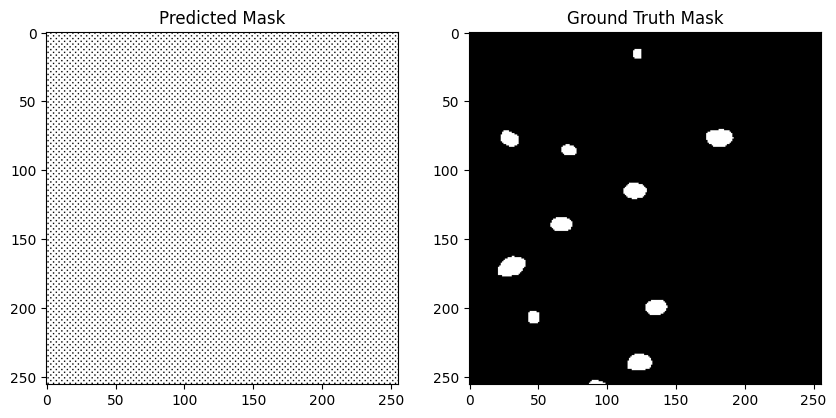

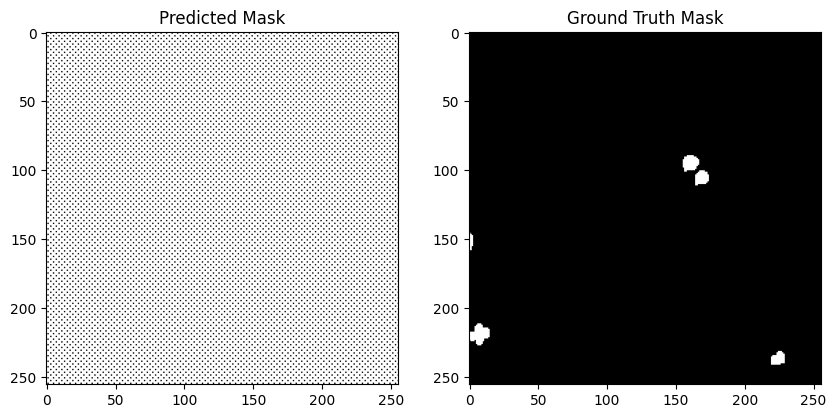

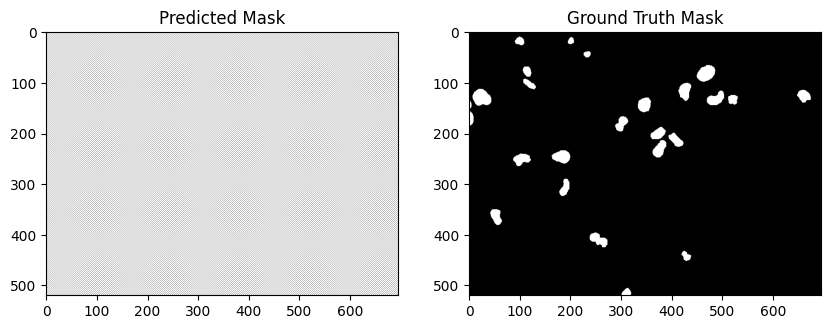

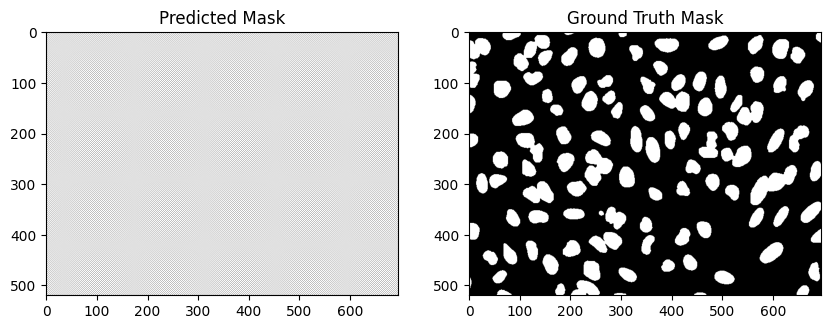

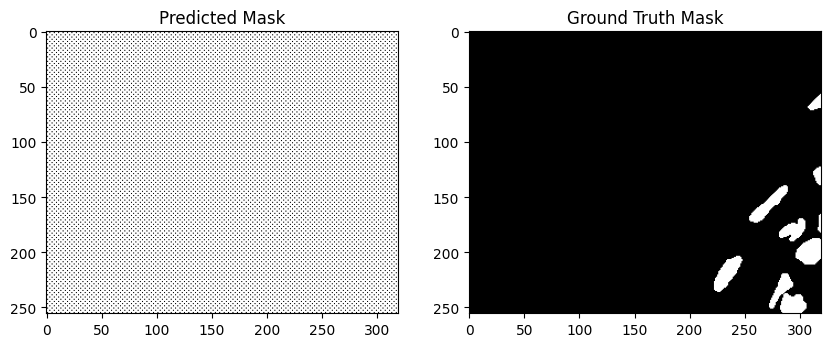

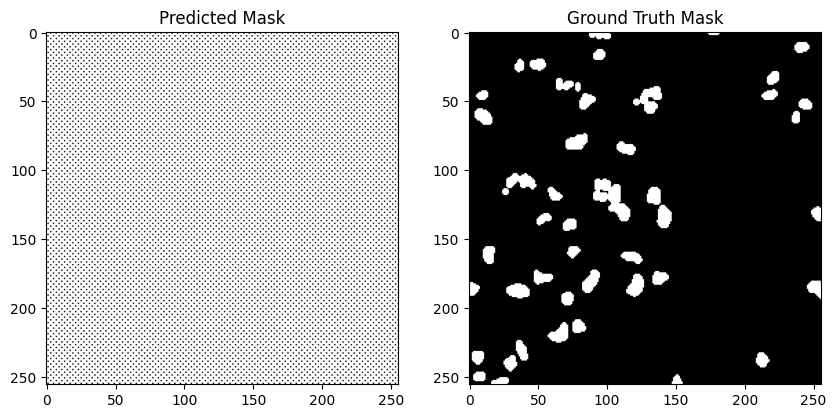

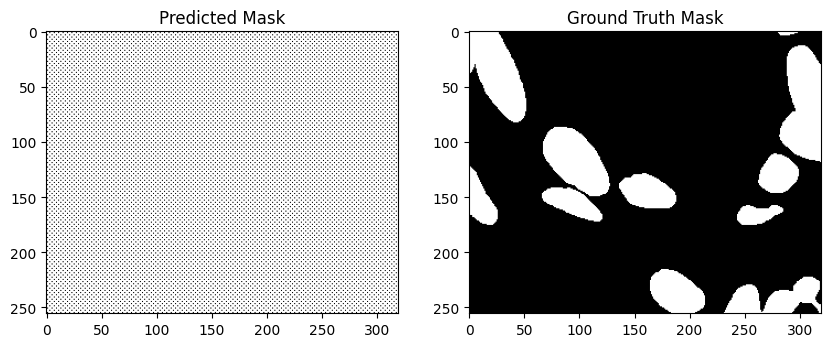

In [70]:
import matplotlib.pyplot as plt

# Calculate average IOU and get masks
avg_iou, masks = calculate_average_iou(model, X_val[:14], Y_val[:14])

# Plot first 10 masks and ground truth masks
for i in range(10):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(masks[i].squeeze(), cmap='gray')
    ax[0].set_title('Predicted Mask')
    ax[1].imshow(Y_val[i].squeeze(), cmap='gray')
    ax[1].set_title('Ground Truth Mask')
    plt.show()


# Kan er geen titelke voor bedenken, doe je ding Tom

In [ ]:
# if shape of the image is smaller than 256-256, resize to 256-256
def small_images_retriever(dataset=X_train, min_h=224, min_w=224):
  small_images=[]
  # get index of images with size smaller than 256x256
  for i in range(dataset.shape[0]):
    if dataset[i].shape[0]<min_h or dataset[i].shape[1]<min_w:
      small_images.append(i)
  return small_images

In [ ]:
import cv2
import numpy as np

def rescale_image(image, min_h=224, min_w=224):
    """
    Rescales an array image to have the minimal height and width of the specified minimums
    while preserving the third dimension of the image.
    
    Args:
    image: numpy array image.
    min_h: integer minimum height of the output image, default 256.
    min_w: integer minimum width of the output image, default 256.
    
    Returns:
    A numpy array of the rescaled image.
    """
    h, w = image.shape[:2]
    scale_factor = max(min_h/h, min_w/w)
    new_h, new_w = int(h*scale_factor), int(w*scale_factor)
    if image.shape[2] == 1:
        rescaled_image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_CUBIC).reshape(new_h, new_w, 1)
    else:
        rescaled_image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_CUBIC)
        
    return rescaled_image

In [ ]:
def cropping(dataset, stride=200, cropping_size=224, X_test=False):
    for i in range (dataset.shape[0]): 
      
    # create crops    
      if X_test:
        print(i)
        dataset[i]= create_overlapping_crops(dataset[i], crop_size= cropping_size, stride=stride)
      else:   
        dataset[i]= create_overlapping_crops(dataset[i], crop_size= cropping_size, stride=stride)
    return dataset


test

In [ ]:
def check_4D_image_value(dataset):
  for i in range(dataset.shape[0]): 
    if dataset[i].shape[2]==4 and np.any(dataset[i][..., -1] != 255):
      print(i)

# Apply the check_4D_image_value function on each dataset
check_4D_image_value(X_train)

check_4D_image_value(X_val)




einde test

In [19]:
from PIL import Image 
import numpy as np

def remove_fourth_dimension(image):
    # add an extra dimension to the third channel
    if image.shape[2]==4:
      
      image=image[:,:,0:3]
    return image

# if the model only needs 3 dimension

# extract the elements from it and put in the list 
def transform_to_sequential_array(dataset, X_test=False):
  output=[]
  for i in range(dataset.shape[0]): 
    if X_test:
        output.append((dataset[i]))
    else: 
      for j in range(dataset[i][0].shape[0]):   
        output.append((dataset[i][0][j]))
  return output

In [ ]:
# remove 4th dimension
for i in range(X_train.shape[0]):
  X_train[i]= remove_fourth_dimension(X_train[i])
# remove 4th dimension
for i in range(X_val.shape[0]):
  X_val[i]= remove_fourth_dimension(X_val[i])



#retieve indexes of small images
# rescale them 

# for train
small_images_train= small_images_retriever(X_train,min_h=224, min_w=224)
# resize these images
for i in small_images_train: 
  X_train[i]= rescale_image(X_train[i])
  Y_train[i]= rescale_image(Y_train[i])

# for validation
small_images_val= small_images_retriever(X_val,min_h=224, min_w=224)
# resize these images
for i in small_images_val: 
  X_val[i]= rescale_image(X_val[i])
  Y_val[i]= rescale_image(Y_val[i])

# #for test
# small_images_test=small_images_retriever(X_test,min_h=224, min_w=224)
# # resize these images
# for i in small_images_test: 
#   X_test[i]= rescale_image(X_test[i])

In [ ]:
# create crops for too large images
X_train= cropping(X_train)
X_val= cropping(X_val)
Y_train=cropping(Y_train)
Y_val= cropping(Y_val)
# X_test=cropping(X_test,X_test=True)

AttributeError: ignored

In [ ]:
# create a list of the observations
X_train_sequential= transform_to_sequential_array(X_train)
Y_train_sequential= transform_to_sequential_array(Y_train)
X_val_sequential= transform_to_sequential_array(X_val)
Y_val_sequential= transform_to_sequential_array(Y_val)
# X_test_sequential= transform_to_sequential_array(X_test, X_test=False)

# Evaluate model on the validation set

In [ ]:
# Uncomment if you want to load in a model
#model = load_model("/content/gdrive/MyDrive/FINAL/InitialModelTrainOnly.h5", custom_objects={'dice_coef_loss': dice_coef_loss,'IoUMetric': IoUMetric})

In [54]:
def calculate_average_iou(model, X_val, Y_val):
    total_iou = 0
    masks = []
    for i in tqdm(range(len(X_val))):
        x = X_val[i]
        img, shape = create_overlapping_crops(x)
        prediction = model.predict(img, verbose=0)
        prediction = (prediction > 0.5).astype(np.uint8)
        overlapping_crops = []
        overlapping_crops.append(prediction)
        overlapping_crops.append(shape)
        mask = recombine_overlapping_crops(overlapping_crops)
        mask = mask[..., :1] 
        val_metric = IoUMetric(Y_val[i], mask)
        total_iou += val_metric
        masks.append(mask)
    avg_iou = total_iou / len(X_val)
    return avg_iou, masks

In [59]:
avg_iou, masks_val = calculate_average_iou(model, X_val, Y_val)
print(avg_iou)

  0%|          | 0/184 [00:00<?, ?it/s]


UnboundLocalError: ignored

In [55]:
def plotValidationSet(X_val, Y_val,preds, indices = val_example_indices ):
    fig, axs = plt.subplots(nrows=3, ncols=len(indices), figsize=(15, 5))
    for i, idx in enumerate(indices):
        # Get the image and its label mask
        x = X_val[idx]
        y = Y_val[idx]
        pred = preds[idx]

        # Plot the image and its label mask as separate subplots
        axs[0][i].imshow(x)
        axs[1][i].imshow(y)
        axs[2][i].imshow(pred)

    plt.show()

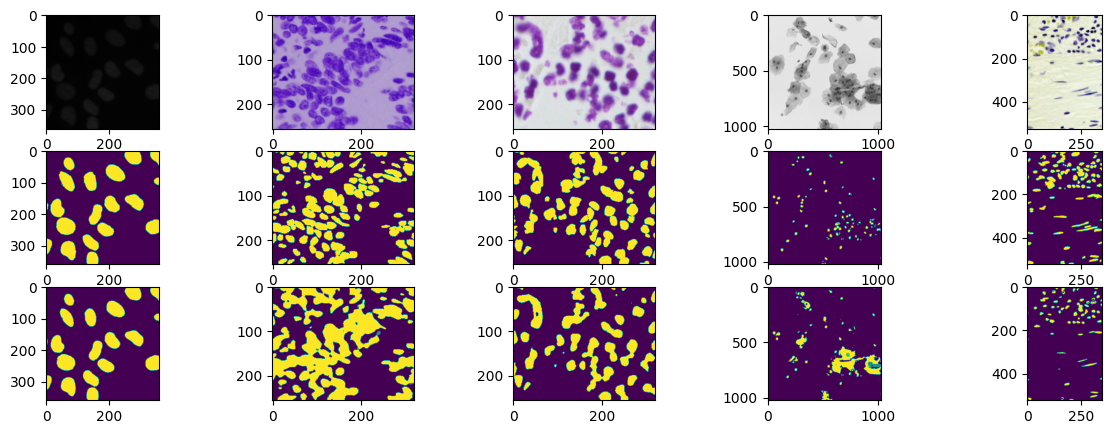

In [ ]:
plotValidationSet(X_val,Y_val,masks_val)

In [ ]:
## Specifically for
val_iou_list = []
for i in range(len(val_example_indices)):
    idx = val_example_indices[i]
    val_metric = IoUMetric(Y_val[idx], masks_val[idx])
    val_iou_list.append(val_metric)
    print(f"Validation IoU for index {idx}: {val_metric:.4f}")
    
val_iou_mean = np.mean(val_iou_list)
print(f"Mean Validation IoU: {val_iou_mean:.4f}")

Validation IoU for index 57: 0.7558
Validation IoU for index 74: 0.0522
Validation IoU for index 56: 0.2513
Validation IoU for index 85: 0.1098
Validation IoU for index 98: 0.0847
Mean Validation IoU: 0.2507


## Retrain on val + train

In [ ]:
all_x= np.concatenate((np.array(X_train), np.array(X_val)))
all_y= np.concatenate((np.array(Y_train), np.array(Y_val)))

In [ ]:
alltrain_generator = RandomCropGenerator(all_x, all_y, crop_size=(128, 128), batch_size=16)

In [ ]:
# Fit model
EPOCHS = 10
BS = 16
results = model.fit(alltrain_generator, 
                    batch_size=BS,
                    epochs = EPOCHS)

Epoch 1/10
46/46 [==============================] - 49s 1s/step - loss: -0.8835
Epoch 2/10
46/46 [==============================] - 29s 642ms/step - loss: -0.8753
Epoch 3/10
46/46 [==============================] - 20s 444ms/step - loss: -0.8851
Epoch 4/10
46/46 [==============================] - 25s 556ms/step - loss: -0.8858
Epoch 5/10
46/46 [==============================] - 19s 430ms/step - loss: -0.8903
Epoch 6/10
46/46 [==============================] - 16s 343ms/step - loss: -0.8786
Epoch 7/10
46/46 [==============================] - 15s 336ms/step - loss: -0.8791
Epoch 8/10
46/46 [==============================] - 19s 361ms/step - loss: -0.8943
Epoch 9/10
46/46 [==============================] - 16s 321ms/step - loss: -0.8918
Epoch 10/10
46/46 [==============================] - 19s 368ms/step - loss: -0.8941


In [ ]:
#model.save("/content/gdrive/MyDrive/FINAL/AllTrainInitial.h5")

In [ ]:
model = load_model("/content/gdrive/MyDrive/FINAL/AllTrainInitial.h5", custom_objects={'dice_coef_loss': dice_coef_loss, 'mean_iou': Current_IoU})

# Test set

## If not loaded

### Unzip 

In [ ]:
!unzip stage2_test_final.zip -d stage2_test_final

Streaming output truncated to the last 5000 lines.
   creating: stage2_test_final/14ff49df48363b4f950a49c08313d933273fe9058dbda881d9579a1700e16dc8/images/
  inflating: stage2_test_final/14ff49df48363b4f950a49c08313d933273fe9058dbda881d9579a1700e16dc8/images/14ff49df48363b4f950a49c08313d933273fe9058dbda881d9579a1700e16dc8.png  
   creating: stage2_test_final/34d0fa5fd2fe5c9955fff299ead6ce97366a2176ad7569afc279c25ba6e0e231/images/
  inflating: stage2_test_final/34d0fa5fd2fe5c9955fff299ead6ce97366a2176ad7569afc279c25ba6e0e231/images/34d0fa5fd2fe5c9955fff299ead6ce97366a2176ad7569afc279c25ba6e0e231.png  
   creating: stage2_test_final/73cd786850fd7161e2b4bc557dbf6743a70cd69f511317c1546d5bb9fd326e17/images/
  inflating: stage2_test_final/73cd786850fd7161e2b4bc557dbf6743a70cd69f511317c1546d5bb9fd326e17/images/73cd786850fd7161e2b4bc557dbf6743a70cd69f511317c1546d5bb9fd326e17.png  
   creating: stage2_test_final/19699898bd07e3d27804bc52fea46d67a8d4c63ec75b5693910482855285fa90/images/
  inflating

### Fill X_test array

In [ ]:
from PIL import Image

# Leave unchanged
TESTSETPATH = "/content/stage2_test_final/"
# Get train and test IDs
testset_ids = next(os.walk(TESTSETPATH))[1]
X_test = []
for n, id_ in tqdm(enumerate(testset_ids), total=len(testset_ids)):
    path = os.path.join(TESTSETPATH, id_)
    img_path = os.path.join(path, 'images', id_ + '.png')
    img = np.array(Image.open(img_path).convert('L'))
    X_test.append(img)

X_test = np.array(X_test)

StopIteration: ignored

## Or load

In [ ]:
FILE_PATH = getFilePath(name='Matteo')
X_test = np.load(FILE_PATH + 'TestData.npy' ,allow_pickle=True)

In [ ]:
def add_channels_and_rgba(arr):
    new_arr = np.zeros((len(arr),), dtype=object)
    
    for i, img in enumerate(arr):
        # Add channels dimension if needed
        if len(img.shape) == 2:
            img = np.expand_dims(img, axis=-1)
        
        # Create an RGBA version of the image
        rgba_img = np.zeros((img.shape[0], img.shape[1], 4), dtype=np.uint8)
        rgba_img[..., :3] = img
        rgba_img[..., 3] = 255
        
        # Assign the RGBA image to the new array
        new_arr[i] = rgba_img
    
    return new_arr

In [ ]:
X_test = add_channels_and_rgba(X_test)

In [ ]:
#### NOG WAT BRAK


# Assuming `X_test` is an array of numpy arrays representing images
unique_shapes = np.unique([x.shape for x in X_test], axis=0)

# Create masks for each group of images with the same shape
preds_test = []
for shape in unique_shapes:
    # Find the indices of the images in X_test with this shape
    indices = [i for i, x in enumerate(X_test) if np.array_equal(x.shape, shape)]
    # Extract the images with this shape into a new array
    batch = np.array([X_test[i] for i in indices])
    # Process the batch
    imgs = []
    shapes = []
    for x in batch:
        img, shape = create_overlapping_crops(x)
        imgs.append(img)
        shapes.append(shape)
    imgs = np.array(imgs)
    predictions = model.predict(imgs)
    predictions = (predictions > 0.5).astype(np.uint8)
    overlapping_crops = []
    overlapping_crops.append(predictions)
    overlapping_crops.append(shapes)
    masks = []
    for y in overlapping_crops:
        mask = recombine_overlapping_crops(y)[..., :1] 
        masks.append(mask)
    # Append the masks to the result list, preserving the order of the original X_test array
    for i, index in enumerate(indices):
        preds_test[index] = masks[0][i]
    # remove the masks list from memory
    del masks[0]

ValueError: ignored

Source image


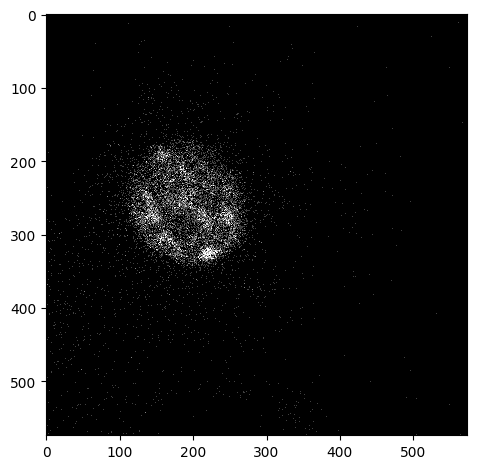

Combined mask image with overlapping objects


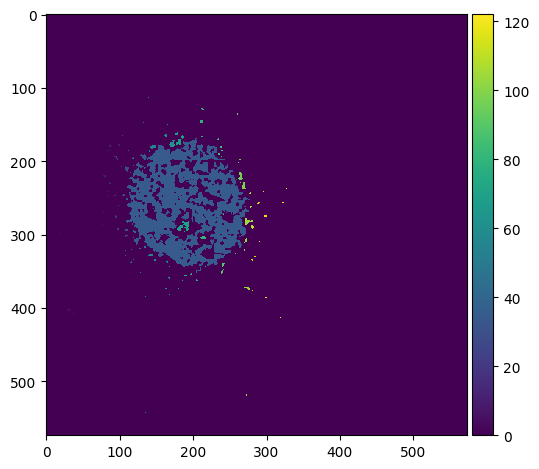

In [ ]:
image_id = testset_ids[0]
img = skimage.io.imread('../content/stage2_test_final/{}/images/{}.png'.format(image_id, image_id))[:, :, :3]
# combine masks as one
mask = preds_test[0]

print("Source image")
imshow(img)
plt.show()

print("Combined mask image with overlapping objects")
labels = label(mask)
imshow(labels)
plt.show()

Source mask image


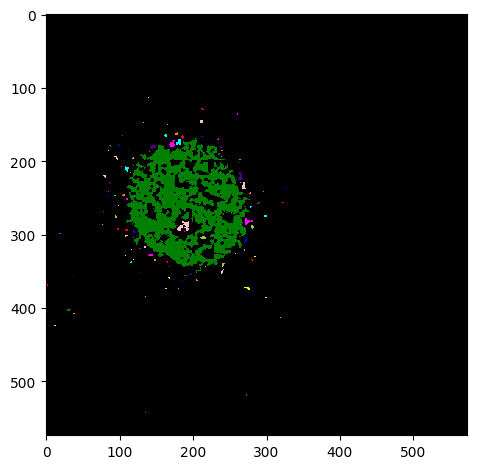

In [ ]:
#check 
reconstructedMask = np.zeros(labels.shape, dtype=np.bool)
labels = labels[:,:,0]
labels = labels.astype(int)

for i in range(1, labels.max() + 1):
    # separate objects
    img_ = separation(labels == i)
    # copy to reconstructed mask
    reconstructedMask = reconstructedMask + img_

labelsFinal = label(reconstructedMask)
      
print("Source mask image")
imshow(label2rgb(labels, bg_label=0))
plt.show()

print("Processed mask image")
imshow(label2rgb(labelsFinal, bg_label=0))
plt.show()

# Submission

In [ ]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

Let's iterate over the test IDs and generate run-length encodings for each seperate mask identified by skimage ...

In [ ]:
first_fifteen = testset_ids[:15]

In [ ]:
new_test_ids = []
rles = []
for n, id_ in enumerate(testset_ids):
    rle = list(prob_to_rles(preds_test[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

... and then finally create our submission!

In [ ]:
print(rles)

AttributeError: ignored

In [ ]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('/content/gdrive/MyDrive/FINAL/sub-dsbowl2018-1.csv', index=False)

This scored 0.233 on the LB for me. That was with version 2 of this notebook; be aware that the results from the neural network are extremely erratic and vary greatly from run to run (version 3 is significantly worse, for example). Version 7 scores 0.277!

You should easily be able to stabilize and improve the results just by changing a few parameters, tweaking the architecture a little bit and training longer with early stopping.

**Have fun!**

LB score history:
- Version 7: 0.277 LB